## Telecom Churn


- **Business Objective**
>- Predict which customers are at high risk of churn and identify main indicators of churn for mainly pre-paid customers  
>- Of the data provided, use Sep month to identify the Churn Label. Then drop the data for Sep and build the model based on Jun-Aug data. Jun-Jul are good phase, Aug is action phase and Sep is churn phase.

<br/>

- **Assumptions/Conditions**  
>- Analyse usage based churn  
>- Focus on high value customers only (Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase))
>- Tagging Churners - Base it on Sep month (Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase). Remove data for Sep month
>- 

- **Steps**
>- Preprocess Data (data type conversions, missing values)
>- Tag Churners
>- EDA
>- Derive new features based on EDA
>- Use PCA to reduce varaiables
>- Handle class imbalance
>- Create models
>- Predict churn (Important to identify churn cases correctly even if some non churn are identified as churn)
>- Evaluate models 
>- Build a model to find variables impacting churn (Use logistic or Decision Trees or Random Foresst)
>- Recomend strategies to manage customer churn


In [236]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime as dt
from math import floor


## Utility Functions

In [237]:
p_disable_plots = False

In [238]:
def setup_defaults():
    pd.options.display.float_format = "{:0,.2f}".format

    #plt.rcParams['figure.dpi'] = 100
    import warnings
    warnings.filterwarnings('ignore')

In [239]:
def missing_values(df: pd.DataFrame) -> pd.DataFrame:
    cols_with_nulls = pd.DataFrame(round(df.isna().sum()/len(df.index)*100, 2), columns=['percent_missing'])
    cols_with_nulls = cols_with_nulls[cols_with_nulls.percent_missing>0].sort_values(by='percent_missing', ascending=False)
    return cols_with_nulls

In [240]:
def generate_count_plts(df, p_col_lst, p_hue, p_rotation=0, p_fig_size=(20, 16)):

    if p_disable_plots:
        return

    i = 1
    ncol = 3
    nrow = int(floor(len(p_col_lst)/ncol)) + 1

    fig = plt.figure(figsize=p_fig_size)

    for col in p_col_lst:
        plt.subplot(nrow, ncol, i)
    
        ax = sns.countplot(data=df, x=col, hue=p_hue)
        plt.xticks(rotation=p_rotation)
        
        i += 1
        
    plt.show()

In [241]:
def generate_box_plts(df, p_col_lst, p_y, p_hue, p_rotation=0, p_fig_size=(20, 8)):

    if p_disable_plots:
        return

    i = 1
    ncol = 3
    nrow = int(floor(len(p_col_lst)/ncol)) + 1

    fig = plt.figure(figsize=p_fig_size)

    for col in p_col_lst:
        plt.subplot(nrow, ncol, i)

        if p_hue is None:
            ax = sns.boxplot(data=df, x=col, y=p_y)
        else:
            ax = sns.boxplot(data=df, x=col, y=p_y, hue=p_hue)

        plt.xticks(rotation=p_rotation)
        
        i += 1
        
    plt.show()

In [242]:
def generate_box_plts_y(df, p_col_lst, p_x, p_hue, p_rotation=0, p_fig_size=(20, 8)):

    if p_disable_plots:
        return

    i = 1
    ncol = 3
    nrow = int(floor(len(p_col_lst)/ncol)) + 1

    fig = plt.figure(figsize=p_fig_size)

    for col in p_col_lst:
        plt.subplot(nrow, ncol, i)

        if p_hue is None:
            ax = sns.boxplot(data=df, x=p_x, y=col)
        else:
            ax = sns.boxplot(data=df, x=p_x, y=col, hue=p_hue)

        plt.xticks(rotation=p_rotation)
        
        i += 1
        
    plt.show()

In [243]:
def generate_single_box_plts(df, p_col_lst, p_fig_size=(20, 8)):
    if p_disable_plots:
        return
        
    plt.figure(figsize=p_fig_size)

    for i, col in enumerate(p_col_lst):
        plt.subplot(3, 3, i+1)
        df[col].plot.box()
        
    plt.show()

In [244]:
def drop_outlier(df1, col, q1:float, q3:float):
    q1 = df1[col].quantile(q1)
    q3 = df1[col].quantile(q3)
    iqr = q3 - q1
    lowerlimit = q1 - 1.5*iqr
    upperlimit = q3 + 1.5*iqr
    #print (q1, q3, iqr, lowerlimit, upperlimit)
    df1 = df1[(df1[col] >= lowerlimit) & (df[col]<=upperlimit)]
    return df1

In [245]:
def generate_percent_plots(p_df, p_x, p_y, p_hue, p_flg=1):
    if p_disable_plots:
        return

    a = p_df.groupby(by=[p_x])[p_hue].value_counts(normalize=True).rename(p_y).reset_index()
    #print(a)
    b = a[a[p_hue]==p_flg]
    b[p_y] = b[p_y]*100
    #print(b)
    sns.barplot(data=b, x=p_x, y=p_y)
    #plt.show()

In [246]:
def generate_percent_multi_plots(p_df, p_col_lst, p_y, p_hue, p_fig_size=(20, 12), p_flg=1):
    if p_disable_plots:
        return

    plt.figure(figsize=p_fig_size)

    for i, col in enumerate(p_col_lst):
        plt.subplot(3, 3, i+1)
        generate_percent_plots(p_df, col, p_y, p_hue, p_flg)
        
    plt.show()

In [247]:
setup_defaults()

## Read Data

In [248]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [249]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/telecom_churn_data.csv')
df.head(3)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,...,150.76,109.61,0.00,212.17,212.17,212.17,nan,212.17,212.17,212.17,nan,0.00,0.00,0.00,nan,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.00,1.00,1.00,nan,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,355.07,268.32,86.28,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,...,0.00,0.00,0.00,nan,0.00,0.00,nan,nan,28.61,7.60,nan,nan,0.00,0.00,nan,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,nan,1.00,1.00,nan,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,189.06,210.23,290.71,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.00,0.00,0.00,38.49,0.00,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,...,0.00,0.00,8.42,nan,nan,nan,2.84,nan,nan,nan,0.00,nan,nan,nan,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,nan,nan,nan,1.00,1103,0.00,0.00,4.17,0.00


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


## Initial Data Analysis

In [251]:
df_int = df.select_dtypes('int64')
df_float = df.select_dtypes('float64')
df_object = df.select_dtypes('object')

In [252]:
cols_with_null_val = missing_values(df_object)
cols_with_null_val

,percent_missing
date_of_last_rech_data_6,74.85
date_of_last_rech_data_7,74.43
date_of_last_rech_data_9,74.08
date_of_last_rech_data_8,73.66
date_of_last_rech_9,4.76
date_of_last_rech_8,3.62
date_of_last_rech_7,1.77
last_date_of_month_9,1.66
date_of_last_rech_6,1.61
last_date_of_month_8,1.10


All variables of type objects are actually dates. Convert to date 

In [253]:
cols_with_null_val = missing_values(df_int)
cols_with_null_val

,percent_missing


In [254]:
cols_with_null_val = missing_values(df_float)
cols_with_null_val[cols_with_null_val.percent_missing>50]

,percent_missing
count_rech_2g_6,74.85
max_rech_data_6,74.85
arpu_3g_6,74.85
count_rech_3g_6,74.85
arpu_2g_6,74.85
night_pck_user_6,74.85
av_rech_amt_data_6,74.85
fb_user_6,74.85
total_rech_data_6,74.85
night_pck_user_7,74.43


In [255]:
df_float.columns[df_float.columns.str.contains('count')]

Index(['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'count_rech_3g_9'],
      dtype='object')

All columns which store counts and are null can be updated to zero

In [256]:
df_float.columns[df_float.columns.str.contains('max')]

Index(['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'max_rech_data_9'],
      dtype='object')

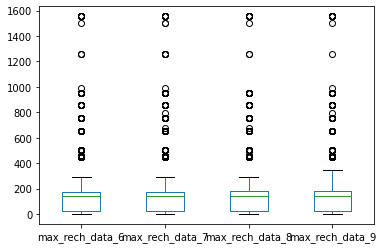

In [257]:
df[df_float.columns[df_float.columns.str.contains('max')]].plot.box()

All columns which store max_rech amounts and are null can be updated to zero

In [258]:
df[cols_with_null_val[cols_with_null_val.percent_missing>50].iloc[:, 0:0].T.columns]

,count_rech_2g_6,max_rech_data_6,arpu_3g_6,count_rech_3g_6,arpu_2g_6,night_pck_user_6,av_rech_amt_data_6,fb_user_6,total_rech_data_6,night_pck_user_7,total_rech_data_7,max_rech_data_7,av_rech_amt_data_7,count_rech_2g_7,arpu_2g_7,fb_user_7,count_rech_3g_7,arpu_3g_7,total_rech_data_9,count_rech_2g_9,count_rech_3g_9,fb_user_9,max_rech_data_9,arpu_2g_9,av_rech_amt_data_9,night_pck_user_9,arpu_3g_9,count_rech_2g_8,fb_user_8,total_rech_data_8,night_pck_user_8,max_rech_data_8,arpu_2g_8,av_rech_amt_data_8,arpu_3g_8,count_rech_3g_8
0,0.00,252.00,212.17,1.00,212.17,0.00,252.00,1.00,1.00,0.00,1.00,252.00,252.00,0.00,212.17,1.00,1.00,212.17,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,1.00,1.00,0.00,252.00,212.17,252.00,212.17,1.00
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,1.00,154.00,154.00,1.00,28.61,1.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00,1.00,2.00,0.00,25.00,7.60,50.00,0.00,0.00
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,1.00,0.00,1.00,46.00,0.00,46.00,0.00,2.84,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,1.00,56.00,0.00,0.00,0.00,0.00,56.00,0.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99995,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99996,2.00,25.00,141.48,0.00,2.40,0.00,39.00,1.00,2.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99997,1.00,202.00,235.68,2.00,235.68,0.00,583.00,1.00,3.00,0.00,2.00,179.00,358.00,0.00,301.34,1.00,2.00,301.34,4.00,0.00,4.00,1.00,252.00,725.68,862.00,0.00,725.69,0.00,1.00,4.00,0.00,179.00,602.68,716.00,602.68,4.00


In [259]:
df[cols_with_null_val[(cols_with_null_val.percent_missing <= 50)
 & (cols_with_null_val.percent_missing > 6)].iloc[:, 0:0].T.columns]

,spl_og_mou_9,std_ic_t2t_mou_9,isd_ic_mou_9,std_ic_t2m_mou_9,isd_og_mou_9,loc_ic_mou_9,std_ic_t2f_mou_9,std_ic_t2o_mou_9,std_og_mou_9,og_others_9,std_ic_mou_9,loc_ic_t2f_mou_9,std_og_t2c_mou_9,spl_ic_mou_9,loc_ic_t2t_mou_9,std_og_t2f_mou_9,offnet_mou_9,loc_og_t2c_mou_9,loc_og_t2f_mou_9,loc_ic_t2m_mou_9,roam_og_mou_9,loc_og_mou_9,std_og_t2t_mou_9,onnet_mou_9,loc_og_t2m_mou_9,std_og_t2m_mou_9,ic_others_9,loc_og_t2t_mou_9,roam_ic_mou_9
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0.00,0.00,0.00,15.01,0.00,173.03,0.00,0.00,0.00,0.00,15.01,0.00,0.00,0.00,116.09,0.00,53.76,0.00,0.00,56.93,0.00,72.11,0.00,18.34,53.76,0.00,0.00,18.34,0.00
2,42.08,49.44,0.01,118.18,0.00,345.41,3.86,0.00,18.04,0.00,171.49,158.19,0.00,0.45,148.23,0.00,118.91,0.48,22.24,38.98,70.94,64.81,8.76,74.81,28.16,9.28,0.36,14.39,38.49
3,43.29,129.84,0.00,13.98,0.00,160.19,0.00,0.00,236.21,0.00,143.83,65.59,0.00,0.55,41.73,0.00,113.54,0.00,2.06,52.86,0.00,83.03,226.21,241.71,65.46,9.99,0.80,15.49,0.00
4,5.98,2.31,0.00,0.00,0.00,202.81,0.00,0.00,0.00,0.00,2.31,0.00,0.00,0.18,154.56,0.00,45.81,0.00,1.93,48.24,0.00,98.61,0.00,58.78,37.89,0.00,0.00,58.78,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0.11,0.00,0.00,0.00,0.00,154.43,0.00,0.00,0.00,0.00,0.00,49.46,0.00,0.00,22.06,0.00,27.14,0.11,2.25,82.89,0.00,27.03,0.00,0.00,24.78,0.00,0.00,0.00,0.00
99995,5.01,0.00,0.00,1.23,0.00,107.61,0.00,0.00,1.90,0.00,1.23,18.44,0.00,0.00,25.71,0.00,56.13,0.00,3.28,63.44,4.23,99.49,0.00,49.49,46.71,1.90,0.00,49.49,0.95
99996,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99997,0.00,0.00,0.00,0.00,0.00,2.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [260]:
df[cols_with_null_val[(cols_with_null_val.percent_missing <= 6)].iloc[:, 0:0].T.columns]

,std_ic_t2t_mou_8,loc_ic_mou_8,loc_ic_t2f_mou_8,std_ic_t2f_mou_8,std_ic_t2m_mou_8,isd_ic_mou_8,std_ic_t2o_mou_8,std_ic_mou_8,spl_ic_mou_8,ic_others_8,loc_ic_t2m_mou_8,loc_og_t2c_mou_8,std_og_t2m_mou_8,roam_ic_mou_8,std_og_t2c_mou_8,isd_og_mou_8,loc_og_t2t_mou_8,spl_og_mou_8,offnet_mou_8,std_og_t2f_mou_8,std_og_mou_8,loc_og_t2m_mou_8,loc_ic_t2t_mou_8,std_og_t2t_mou_8,loc_og_t2f_mou_8,loc_og_mou_8,og_others_8,roam_og_mou_8,onnet_mou_8,std_og_t2t_mou_6,loc_og_t2m_mou_6,std_og_t2c_mou_6,isd_ic_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,loc_og_mou_6,std_og_mou_6,loc_og_t2t_mou_6,spl_ic_mou_6,loc_og_t2f_mou_6,...,loc_og_t2c_mou_6,std_ic_mou_6,roam_ic_mou_6,std_ic_t2f_mou_6,spl_og_mou_6,std_ic_t2o_mou_6,roam_og_mou_6,isd_og_mou_6,loc_og_t2m_mou_7,offnet_mou_7,roam_ic_mou_7,loc_og_t2t_mou_7,loc_og_t2f_mou_7,onnet_mou_7,roam_og_mou_7,loc_ic_t2m_mou_7,loc_og_t2c_mou_7,loc_og_mou_7,loc_ic_t2f_mou_7,loc_ic_t2t_mou_7,loc_ic_mou_7,std_ic_t2t_mou_7,og_others_7,std_ic_t2m_mou_7,spl_og_mou_7,std_ic_t2f_mou_7,std_ic_t2o_mou_7,isd_og_mou_7,std_ic_mou_7,std_og_mou_7,spl_ic_mou_7,isd_ic_mou_7,std_og_t2c_mou_7,ic_others_7,std_og_t2f_mou_7,std_og_t2m_mou_7,std_og_t2t_mou_7,std_og_t2o_mou,loc_ic_t2o_mou,loc_og_t2o_mou
0,0.00,5.44,1.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00
1,2.35,408.43,3.61,0.00,12.49,0.00,0.00,14.84,0.00,0.00,375.58,0.00,0.13,0.00,0.00,0.00,7.68,12.76,304.76,0.00,0.13,291.86,29.23,0.00,0.00,299.54,0.00,0.00,7.68,0.23,11.51,0.00,1.83,0.00,0.00,35.39,0.23,23.88,0.00,0.00,...,0.00,5.90,0.00,0.00,4.68,0.00,0.00,0.00,75.94,99.84,0.00,74.56,0.00,78.68,0.00,65.38,2.91,150.51,8.93,29.91,104.23,0.00,0.00,0.00,23.43,0.00,0.00,0.00,0.00,4.58,0.00,0.00,0.00,0.00,0.00,0.46,4.11,0.00,0.00,0.00
2,28.69,155.99,49.63,43.23,167.09,0.00,0.00,239.03,0.00,0.00,38.89,45.76,75.53,0.00,0.00,0.00,13.58,96.84,208.36,22.83,120.94,38.46,67.46,22.58,15.61,67.66,0.00,0.00,37.26,4.34,29.34,0.00,0.00,41.81,1.48,60.66,47.64,7.19,0.21,24.11,...,0.00,139.33,0.00,21.73,46.56,0.00,0.00,0.00,16.86,220.59,0.00,28.74,21.79,55.24,0.00,15.44,135.54,67.41,122.29,71.11,208.86,71.29,0.00,177.01,236.84,58.34,0.00,0.00,306.66,108.68,0.00,0.85,0.00,3.14,14.76,67.41,26.49,0.00,0.00,0.00
3,0.00,48.18,19.84,0.00,4.94,0.00,0.00,4.94,0.00,0.00,20.28,0.00,6.53,44.38,0.00,0.00,10.61,18.09,71.68,0.00,296.11,22.46,8.04,289.58,4.91,37.99,0.00,39.04,310.98,26.23,107.43,0.00,0.00,2.99,0.00,183.03,29.23,73.68,0.59,1.91,...,0.00,45.99,0.00,1.18,10.96,0.00,0.00,0.00,83.21,109.01,54.86,34.81,0.65,54.39,28.09,64.51,0.00,118.68,27.09,19.98,111.59,66.44,0.00,38.56,0.00,0.00,0.00,0.00,105.01,16.63,0.00,0.00,0.00,0.00,0.00,1.73,14.89,0.00,0.00,0.00
4,0.86,337.94,0.00,0.00,0.00,0.00,0.00,0.86,0.00,0.00,104.13,0.00,0.00,0.00,0.00,0.00,83.89,0.00,124.26,0.00,0.00,124.26,233.81,0.00,0.00,208.16,0.00,0.00,83.89,0.00,67.64,0.00,0.00,9.31,0.00,117.96,9.31,50.31,0.00,0.00,...,0.00,1.93,0.00,0.00,0.00,0.00,0.00,0.00,91.88,91.88,0.00,149.44,0.00,149.44,0.00,109.54,0.00,241.33,0.00,88.49,198.04,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0.00,160.83,43.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,76.08,3.21,0.00,0.00,0.00,0.00,5.91,3.21,52.79,0.00,0.00,49.58,40.94,0.00,0.00,55.49,0.00,0.00,5.91,0.00,12.78,0.00,0.00,0.00,0.00,18.18,0.00,5.40,0.00,0.00,...,0.00,0.00,0.00,0.00,2.41,0.00,0.00,0.00,54.46,54.46,0.00,3.36,0.00,3.36,0.00,46.93,0.00,57.83

In [261]:
# lets look at some rows for June
df[df_float.columns[df_float.columns.str.contains('_6')]][0:10].T

,0,1,2,3,4,5,6,7,8,9
arpu_6,197.38,34.05,167.69,221.34,261.64,50.26,429.02,"1,069.18",378.72,119.52
onnet_mou_6,nan,24.11,11.54,99.91,50.31,50.16,71.03,57.84,413.69,33.89
offnet_mou_6,nan,15.74,143.33,123.31,76.96,19.28,262.73,453.43,94.66,63.48
roam_ic_mou_6,nan,0.00,0.00,0.00,0.00,0.00,0.00,16.23,0.00,0.00
roam_og_mou_6,nan,0.00,0.00,0.00,0.00,0.00,0.00,23.74,0.00,0.00
loc_og_t2t_mou_6,nan,23.88,7.19,73.68,50.31,50.16,71.03,51.39,297.13,33.89
loc_og_t2m_mou_6,nan,11.51,29.34,107.43,67.64,16.39,252.23,308.63,80.96,38.03
loc_og_t2f_mou_6,nan,0.00,24.11,1.91,0.00,0.00,10.38,62.13,0.00,0.00
loc_og_t2c_mou_6,nan,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,0.00
loc_og_mou_6,nan,35.39,60.66,183.03,117.96,66.56,333.64,422.16,378.09,71.93


## Initial Data Analysis Results

>- All object data types are dates. Convert them
>- All float data with null values can be safely updated to zero

## Data Preprocessing

* **Data type conversion**
>- Objects to dates 

* **Missing data**
>- All variables which store counts can be updated to zero
>- All columns which store max_rech amounts and are null can be updated to zero
>- All float data with null values can be safely updated to zero 
>- Convert date fields to 0's and 1's

In [262]:
df[df_object.columns]

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
99994,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/3/2014,7/20/2014,8/26/2014,9/25/2014,NaN,NaN,NaN,NaN
99995,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/17/2014,8/24/2014,9/26/2014,NaN,NaN,NaN,NaN
99996,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/13/2014,7/26/2014,NaN,9/2/2014,6/13/2014,NaN,NaN,NaN
99997,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/19/2014,8/20/2014,9/17/2014,6/17/2014,7/19/2014,8/20/2014,9/17/2014


Convert date variables to datetime 

In [263]:
for col in df_object.columns:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y')

For float variables with null values, update to zero

In [264]:
df[df_float.columns] = df[df_float.columns].fillna(0)

In [265]:
cols_with_null_val = missing_values(df)
cols_with_null_val

,percent_missing
date_of_last_rech_data_6,74.85
date_of_last_rech_data_7,74.43
date_of_last_rech_data_9,74.08
date_of_last_rech_data_8,73.66
date_of_last_rech_9,4.76
date_of_last_rech_8,3.62
date_of_last_rech_7,1.77
last_date_of_month_9,1.66
date_of_last_rech_6,1.61
last_date_of_month_8,1.10


Now the only values that are null are the dates

In [266]:
# def max_date(d1, d2, d3, d4):
#     lst = [d1, d2, d3, d4]
#     mx_date = dt.datetime(1900, 1, 1)
#     for d in lst:
#         if d is not None and d > mx_date: 
#             mx_date = d
#     return None if mx_date==dt.datetime(1900, 1, 1) else mx_date

In [267]:
# l = list(df_object.columns)
# l.insert(0, 'max_last_rech')
# l.insert(1, 'max_last_data_rech')

# df['max_last_rech'] = df.apply(lambda row :max_date(row['date_of_last_rech_6'], row['date_of_last_rech_7'], row['date_of_last_rech_8'], row['date_of_last_rech_9']), axis=1)
# df['max_last_data_rech'] = df.apply(lambda row :max_date(row['date_of_last_rech_data_6'], row['date_of_last_rech_data_7'], row['date_of_last_rech_data_8'], row['date_of_last_rech_data_9']), axis=1)

# df[l].head(10)

In [268]:
#df['overall_max_last_rech'] = df.apply(lambda row :max_date(row['max_last_rech'], row['max_last_data_rech'], None, None), axis=1)

In [269]:
#df[df['overall_max_last_rech'].isna()]

In [270]:
df['last_mnt_flg_6'] = df.last_date_of_month_8.map(lambda x : 0 if pd.isna(x) else 1)
df['last_mnt_flg_7'] = df.last_date_of_month_8.map(lambda x : 0 if pd.isna(x) else 1)
df['last_mnt_flg_8'] = df.last_date_of_month_8.map(lambda x : 0 if pd.isna(x) else 1)
df['last_mnt_flg_9'] = df.last_date_of_month_8.map(lambda x : 0 if pd.isna(x) else 1)

In [271]:
df['last_rech_flg_6'] = df.date_of_last_rech_6.map(lambda x : 0 if pd.isna(x) else 1)
df['last_rech_flg_7'] = df.date_of_last_rech_7.map(lambda x : 0 if pd.isna(x) else 1)
df['last_rech_flg_8'] = df.date_of_last_rech_8.map(lambda x : 0 if pd.isna(x) else 1)
df['last_rech_flg_9'] = df.date_of_last_rech_9.map(lambda x : 0 if pd.isna(x) else 1)

In [272]:
df['last_rech_data_flg_6'] = df.date_of_last_rech_data_6.map(lambda x : 0 if pd.isna(x) else 1)
df['last_rech_data_flg_7'] = df.date_of_last_rech_data_7.map(lambda x : 0 if pd.isna(x) else 1)
df['last_rech_data_flg_8'] = df.date_of_last_rech_data_8.map(lambda x : 0 if pd.isna(x) else 1)
df['last_rech_data_flg_9'] = df.date_of_last_rech_data_9.map(lambda x : 0 if pd.isna(x) else 1)

In [273]:
df = df.rename(mapper={ 'jun_vbc_3g':'vbc_3g_6', 'jul_vbc_3g':'vbc_3g_7', 'aug_vbc_3g' :'vbc_3g_8'}, axis=1)


## Filter High Value Customers

>- High-value customers are those who have recharged with an amount more than or equal to X, 
where X is the 70th percentile of the average recharge amount in the first two months i.e June and July
>- grand_total_recharge_6 = total_rech_amt_6 + total_rech_amt_data_6 where total_rech_amt_data_6 = total_rech_data_6 * av_rech_amt_data_6
>- average_recharge_6_7 = average(grand_total_recharge_6, grand_total_recharge_7)
>- drop all customers who are below 70 percentile

In [274]:
df[df.total_rech_data_6>1][['total_rech_amt_6', 'total_rech_data_6', 'av_rech_amt_data_6']]

,total_rech_amt_6,total_rech_data_6,av_rech_amt_data_6
32,69,3.00,64.00
33,1058,5.00,"1,057.00"
53,1159,4.00,86.00
56,528,2.00,308.00
57,1389,4.00,"1,311.00"
...,...,...,...
99956,74,2.00,34.00
99957,1376,3.00,350.00
99969,148,3.00,138.00
99996,119,2.00,39.00


In [275]:
df['grand_total_rech_amt_6'] = df.total_rech_amt_6 + (df.total_rech_data_6 * df.av_rech_amt_data_6)
df['grand_total_rech_amt_7'] = df.total_rech_amt_7 + (df.total_rech_data_7 * df.av_rech_amt_data_7)

In [276]:
df[['grand_total_rech_amt_6', 'total_rech_amt_6', 'total_rech_data_6', 'av_rech_amt_data_6', 'grand_total_rech_amt_6', 
'total_rech_amt_7', 'total_rech_data_7', 'av_rech_amt_data_7', 'grand_total_rech_amt_7']].head(5)

,grand_total_rech_amt_6,total_rech_amt_6,total_rech_data_6,av_rech_amt_data_6,grand_total_rech_amt_6,total_rech_amt_7,total_rech_data_7,av_rech_amt_data_7,grand_total_rech_amt_7
0,614.00,362,1.00,252.00,614.00,252,1.00,252.00,504.00
1,74.00,74,0.00,0.00,74.00,384,1.00,154.00,538.00
2,168.00,168,0.00,0.00,168.00,315,0.00,0.00,315.00
3,230.00,230,0.00,0.00,230.00,310,0.00,0.00,310.00
4,252.00,196,1.00,56.00,252.00,350,0.00,0.00,350.00


In [277]:
df['average_recharge_6_7'] = (df.grand_total_rech_amt_6 + df.grand_total_rech_amt_7)/2

In [278]:
df.average_recharge_6_7.describe(percentiles=[0.7])

count   99,999.00
mean       485.33
std        869.42
min          0.00
50%        275.00
70%        478.00
max     61,236.00
Name: average_recharge_6_7, dtype: float64

In [279]:
df_hv = df[df.average_recharge_6_7 >= 478]
df_hv.shape

(30001, 241)

## Derive Target Label (Tag Churners)

>- Based on Sep month, tag those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase). Remove data for Sep month
>- Variables are total_ic_mou_9, roam_ic_mou_9, total_og_mou_9, roam_og_mou_9,  vol_2g_mb_9, vol_3g_mb_9. Roam fields will not be used since business does not want it to be used
>- total_ic_mou_9 includes all incoming categories except for roaming. Same for total_og_mou_9
>- Thus total_usage = total_ic_mou_9 + total_og_mou_9 + vol_2g_mb_9 + vol_3g_mb_9
>- Thus churn_label = if total_usage > 0 then will_not_churn else will_churn
>- Drop Sep data so that we do not use it for any analysis at all

In [280]:
#Roam fields will not be used since business does not want it to be used
#df['total_usage'] = df.total_ic_mou_9 + df.roam_ic_mou_9 + df.total_og_mou_9 + df.roam_og_mou_9 + df.vol_2g_mb_9 + df.vol_3g_mb_9
df_hv['total_usage'] = df_hv.total_ic_mou_9 + df_hv.total_og_mou_9 + df_hv.vol_2g_mb_9 + df_hv.vol_3g_mb_9

In [281]:
df_hv['churn'] = df_hv.total_usage.map(lambda x : 0 if x > 0 else 1)

In [282]:
round(df_hv.churn.value_counts()/len(df_hv) * 100, 2)

0   91.86
1    8.14
Name: churn, dtype: float64

In [283]:
df_hv = df_hv.drop(df_hv.columns[df_hv.columns.str.contains('_9')], axis=1)
df_hv = df_hv.drop(['total_usage', 'sep_vbc_3g'], axis=1)
df_hv.shape

(30001, 184)

In [284]:
df_hv.head(3)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,...,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,last_mnt_flg_6,last_mnt_flg_7,last_mnt_flg_8,last_rech_flg_6,last_rech_flg_7,last_rech_flg_8,last_rech_data_flg_6,last_rech_data_flg_7,last_rech_data_flg_8,grand_total_rech_amt_6,grand_total_rech_amt_7,average_recharge_6_7,churn
0,7000842753,109,0.00,0.00,0.00,2014-06-30,2014-07-31,2014-08-31,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,212.17,212.17,212.17,212.17,212.17,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,1,1,1,1,1,1,1,1,1,614.00,504.00,559.00,1
7,7000701601,109,0.00,0.00,0.00,2014-06-30,2014-07-31,2014-08-31,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,802,57.74,19.38,18.74,1,1,1,1,1,1,0,0,0,"1,580.00",790.00,"1,185.00",1
8,7001524846,109,0.00,0.00,0.00,2014-06-30,2014-07-31,2014-08-31,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,...,0.00,19.83,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,1,3,0,0,0,0,0,0,0.00,1.00,1.00,315,21.03,910.65,122.16,1,1,1,1,1,1,0,1,1,437.00,955.00,696.00,0


## EDA

>- Check for outliers
>- Check for corelations between churn and categorical variables
>- Check for multicolinearity

In [285]:
df_hv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 184 entries, mobile_number to churn
dtypes: datetime64[ns](9), float64(138), int64(37)
memory usage: 42.3 MB


### Univariate Analysis

#### Analysis of Categorical columns

In [286]:
cat_cols = ['fb_user_6',
'fb_user_7',
'fb_user_8',
'monthly_2g_6',
'monthly_2g_7',
'monthly_2g_8',
'monthly_3g_6',
'monthly_3g_7',
'monthly_3g_8',
'night_pck_user_6',
'night_pck_user_7',
'night_pck_user_8',
'sachet_2g_6',
'sachet_2g_7',
'sachet_2g_8',
'sachet_3g_6',
'sachet_3g_7',
'sachet_3g_8'
]

In [287]:
df_hv.circle_id.value_counts()

109    30001
Name: circle_id, dtype: int64

In [288]:
df_hv.aon.describe(percentiles=[0.25, 0.75, 0.8, 0.9, 0.95, 0.99])

count   30,001.00
mean     1,209.37
std        957.68
min        180.00
25%        460.00
50%        846.00
75%      1,756.00
80%      2,204.00
90%      2,793.00
95%      3,140.00
99%      3,651.00
max      4,321.00
Name: aon, dtype: float64

In [289]:
df_hv['aon_yrs'] = pd.cut(df_hv.aon, [ d*365 for d in range(13)], labels=[ d for d in range(1, 13)])

In [290]:
cat_cols.append('aon_yrs')

In [291]:
df_hv[cat_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
fb_user_6,"30,001.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
fb_user_7,"30,001.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
fb_user_8,"30,001.00",0.48,0.50,0.00,0.00,0.00,1.00,1.00
monthly_2g_6,"30,001.00",0.17,0.43,0.00,0.00,0.00,0.00,4.00
monthly_2g_7,"30,001.00",0.18,0.45,0.00,0.00,0.00,0.00,5.00
monthly_2g_8,"30,001.00",0.15,0.41,0.00,0.00,0.00,0.00,5.00
monthly_3g_6,"30,001.00",0.22,0.61,0.00,0.00,0.00,0.00,14.00
monthly_3g_7,"30,001.00",0.23,0.66,0.00,0.00,0.00,0.00,16.00
monthly_3g_8,"30,001.00",0.21,0.62,0.00,0.00,0.00,0.00,16.00
night_pck_user_6,"30,001.00",0.01,0.12,0.00,0.00,0.00,0.00,1.00


In [292]:
df_hv[['loc_ic_t2o_mou', 'loc_og_t2o_mou', 'std_og_t2o_mou']].describe()

,loc_ic_t2o_mou,loc_og_t2o_mou,std_og_t2o_mou
count,"30,001.00","30,001.00","30,001.00"
mean,0.00,0.00,0.00
std,0.00,0.00,0.00
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,0.00
max,0.00,0.00,0.00


#### Categorical Plots

**Check what percentage of churn.**

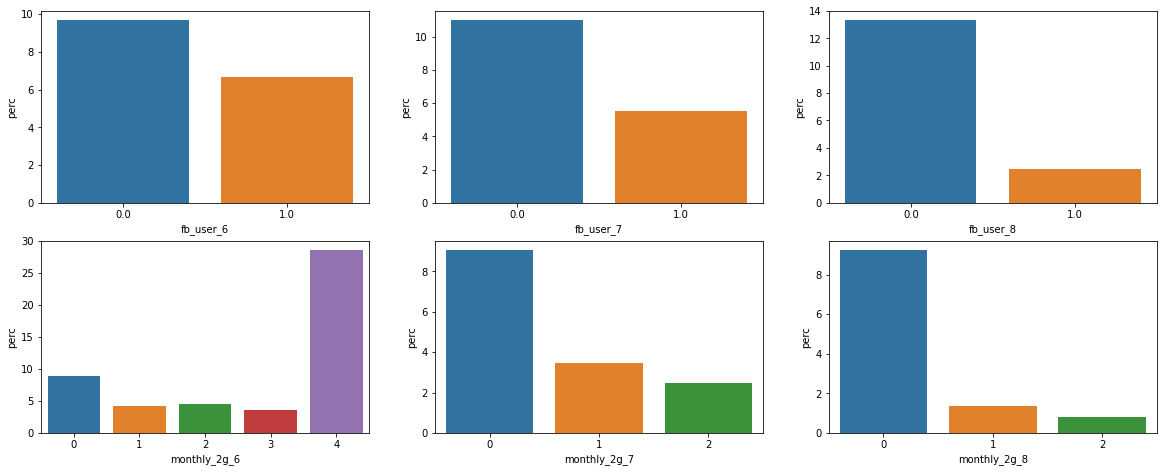

In [293]:
generate_percent_multi_plots(df_hv, cat_cols[0:6], 'perc', 'churn')

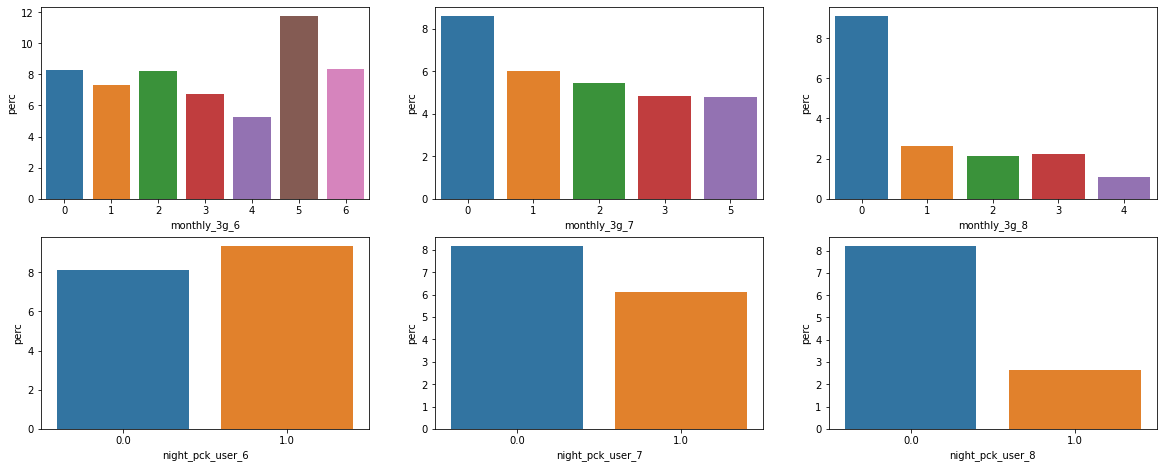

In [294]:
generate_percent_multi_plots(df_hv, cat_cols[6:12], 'perc', 'churn')

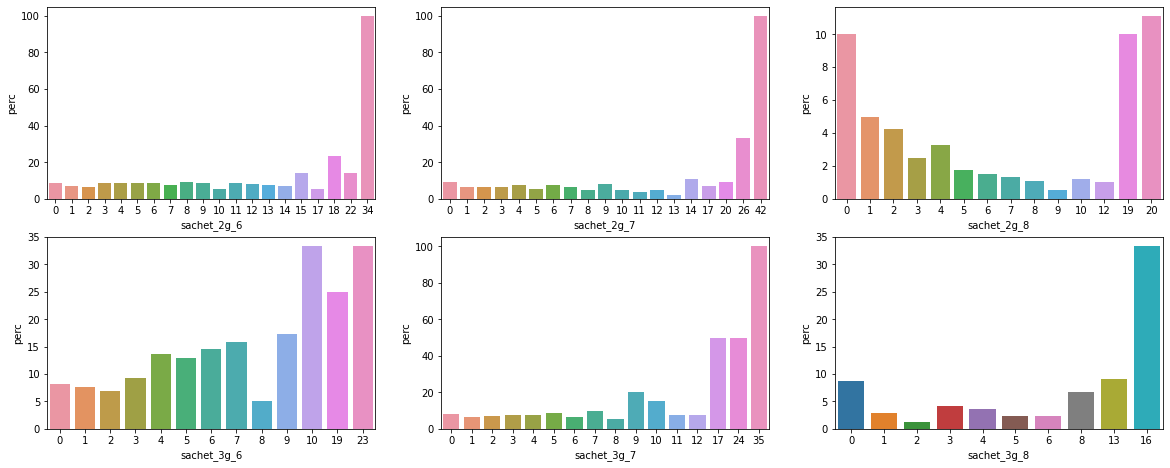

In [295]:
generate_percent_multi_plots(df_hv, cat_cols[12:18], 'perc', 'churn')

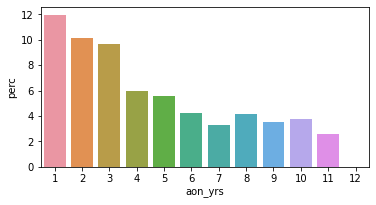

In [296]:
generate_percent_multi_plots(df_hv, cat_cols[18:19], 'perc', 'churn', p_fig_size=(20, 10))

In [297]:
date_flg_cols = ['last_mnt_flg_6',
'last_mnt_flg_7',
'last_mnt_flg_8',
'last_rech_data_flg_6',
'last_rech_data_flg_7',
'last_rech_data_flg_8',
'last_rech_flg_6',
'last_rech_flg_7',
'last_rech_flg_8',
]

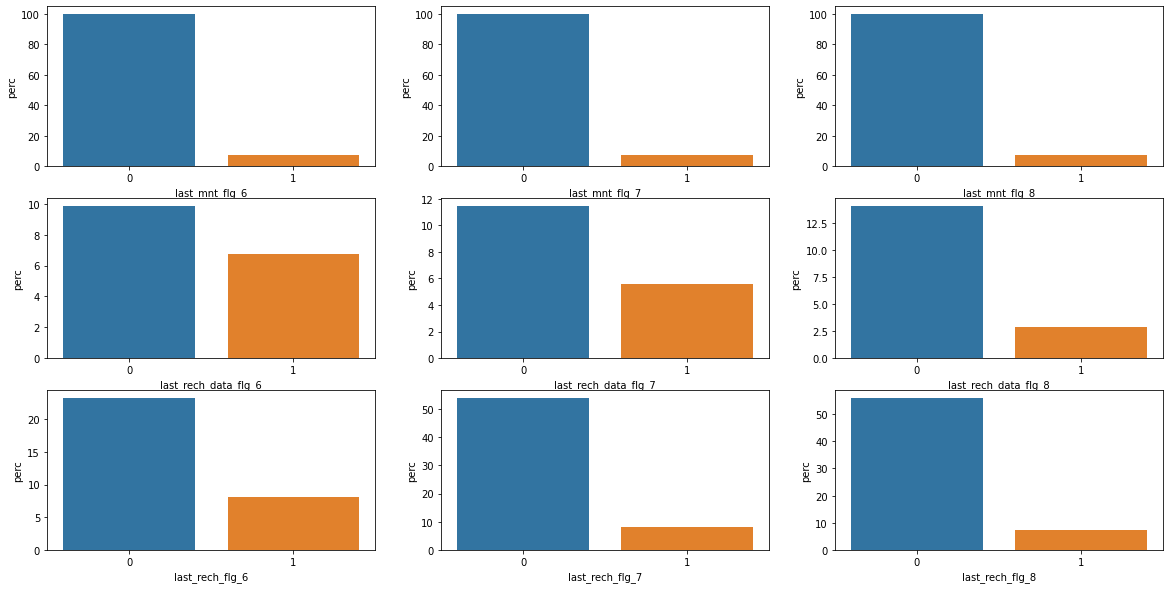

In [298]:
generate_percent_multi_plots(df_hv, date_flg_cols[0:9], 'perc', 'churn', p_fig_size=(20, 10), p_flg=1)

#### Revenue Columns Analysis

In [299]:
revenue_cols = ['arpu_2g_6',
'arpu_2g_7',
'arpu_2g_8',
'arpu_3g_6',
'arpu_3g_7',
'arpu_3g_8',
'arpu_6',
'arpu_7',
'arpu_8',
'av_rech_amt_data_6',
'av_rech_amt_data_7',
'av_rech_amt_data_8',
'count_rech_2g_6',
'count_rech_2g_7',
'count_rech_2g_8',
'count_rech_3g_6',
'count_rech_3g_7',
'count_rech_3g_8',
'max_rech_amt_6',
'max_rech_amt_7',
'max_rech_amt_8',
'max_rech_data_6',
'max_rech_data_7',
'max_rech_data_8',
'total_rech_amt_6',
'total_rech_amt_7',
'total_rech_amt_8',
'total_rech_data_6',
'total_rech_data_7',
'total_rech_data_8',
'total_rech_num_6',
'total_rech_num_7',
'total_rech_num_8',
'vbc_3g_7',
'vbc_3g_6',
'vbc_3g_8',
'grand_total_rech_amt_6',
'grand_total_rech_amt_7',
'average_recharge_6_7',
]

In [300]:
df_hv[revenue_cols].describe(percentiles=[0.25, 0.75, 0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,25%,50%,75%,80%,90%,95%,99%,max
arpu_2g_6,"30,001.00",63.44,161.01,-15.32,0.00,0.00,50.67,85.00,212.17,362.84,675.49,"6,433.76"
arpu_2g_7,"30,001.00",64.70,165.28,-15.48,0.00,0.00,47.22,85.01,212.17,371.13,758.58,"4,809.36"
arpu_2g_8,"30,001.00",58.40,152.63,-24.43,0.00,0.00,26.90,66.09,212.17,334.24,712.28,"3,467.17"
arpu_3g_6,"30,001.00",67.01,179.16,-30.28,0.00,0.00,35.00,77.68,216.65,397.89,811.93,"6,362.28"
arpu_3g_7,"30,001.00",68.62,183.13,-26.04,0.00,0.00,35.69,79.91,215.72,407.97,817.92,"4,980.90"
arpu_3g_8,"30,001.00",62.77,170.17,-24.49,0.00,0.00,20.92,64.29,212.38,389.00,794.93,"3,716.90"
arpu_6,"30,001.00",558.49,460.64,"-2,258.71",309.87,481.69,699.94,768.30,994.10,"1,240.96","1,985.12","27,731.09"
arpu_7,"30,001.00",560.78,479.78,"-2,014.05",309.83,480.94,698.32,770.40,995.86,"1,261.27","1,999.50","35,145.83"
arpu_8,"30,001.00",508.60,501.96,-945.81,231.47,427.58,661.49,735.93,977.35,"1,255.02","1,986.62","33,543.62"
av_rech_amt_data_6,"30,001.00",130.65,200.33,0.00,0.00,50.00,198.00,252.00,308.00,495.00,813.00,"7,546.00"


**Massive Outliers can be seen after 95%. Drop of the rows for some of the key columns and recheck**

In [301]:
tmp_lst = ['arpu_6', 'arpu_7', 'arpu_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'grand_total_rech_amt_6', 'grand_total_rech_amt_7']

for col in tmp_lst:
    df_hv = drop_outlier(df_hv, col, 0.0, 0.95)
    
df_hv[revenue_cols].describe(percentiles=[0.25, 0.75, 0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,25%,50%,75%,80%,90%,95%,99%,max
arpu_2g_6,"29,473.00",56.54,128.27,-15.32,0.00,0.00,43.82,77.68,212.17,304.29,636.51,"1,685.10"
arpu_2g_7,"29,473.00",56.95,130.90,-15.48,0.00,0.00,41.82,77.68,212.17,303.25,636.51,"2,139.55"
arpu_2g_8,"29,473.00",52.95,131.83,-24.43,0.00,0.00,22.67,63.96,212.17,289.85,636.51,"2,447.57"
arpu_3g_6,"29,473.00",59.21,144.46,-30.28,0.00,0.00,28.00,69.97,212.19,355.90,682.40,"2,882.55"
arpu_3g_7,"29,473.00",60.11,146.51,-26.04,0.00,0.00,29.16,71.45,212.19,367.96,692.48,"2,139.59"
arpu_3g_8,"29,473.00",56.72,147.36,-24.49,0.00,0.00,15.48,63.96,212.18,335.41,700.08,"3,716.90"
arpu_6,"29,473.00",542.27,356.79,-810.66,308.34,478.92,691.68,758.42,969.60,"1,201.30","1,786.44","4,497.68"
arpu_7,"29,473.00",542.45,353.05,"-1,289.71",308.13,478.17,690.00,759.45,970.26,"1,208.80","1,783.69","3,443.23"
arpu_8,"29,473.00",491.90,380.21,-345.13,230.02,425.61,653.92,726.10,954.45,"1,217.48","1,816.23","3,628.94"
av_rech_amt_data_6,"29,473.00",121.97,166.52,0.00,0.00,46.00,198.00,252.00,308.00,455.00,756.00,"1,954.00"


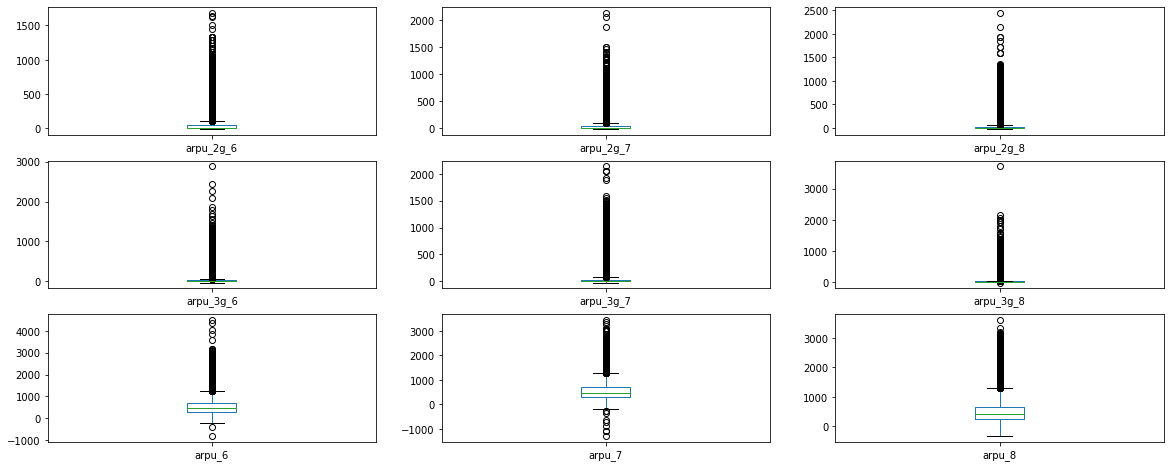

In [302]:
generate_single_box_plts(df_hv, revenue_cols[0:9])

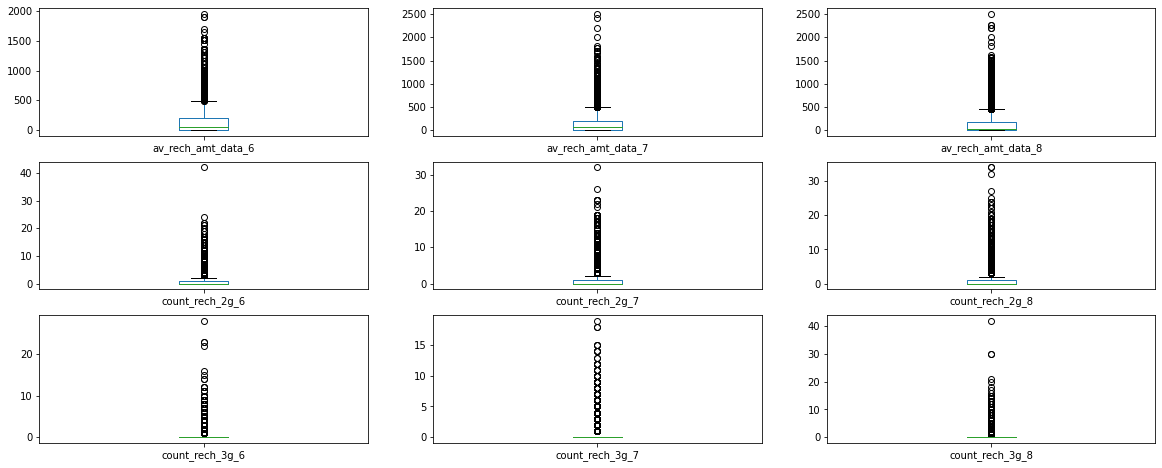

In [303]:
generate_single_box_plts(df_hv, revenue_cols[9:18])

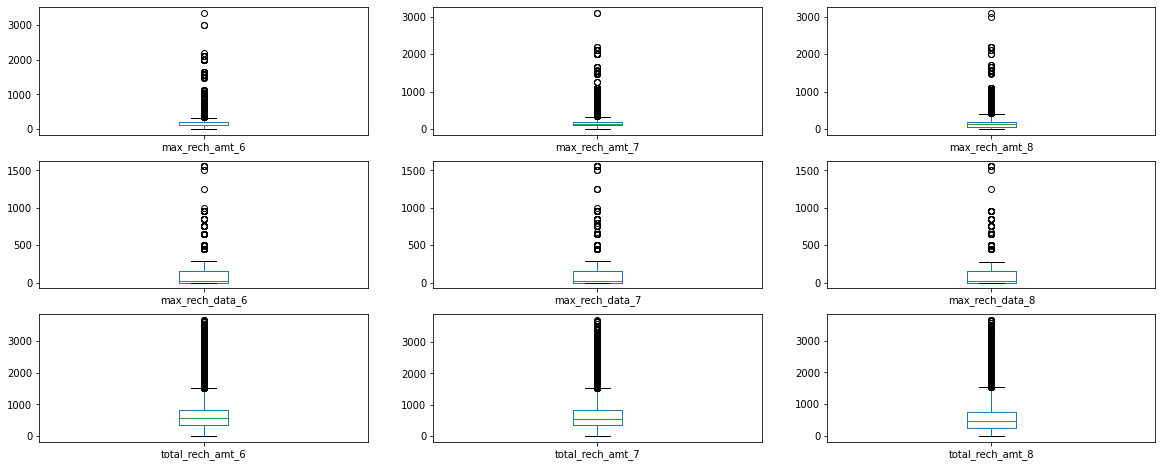

In [304]:
generate_single_box_plts(df_hv, revenue_cols[18:27])

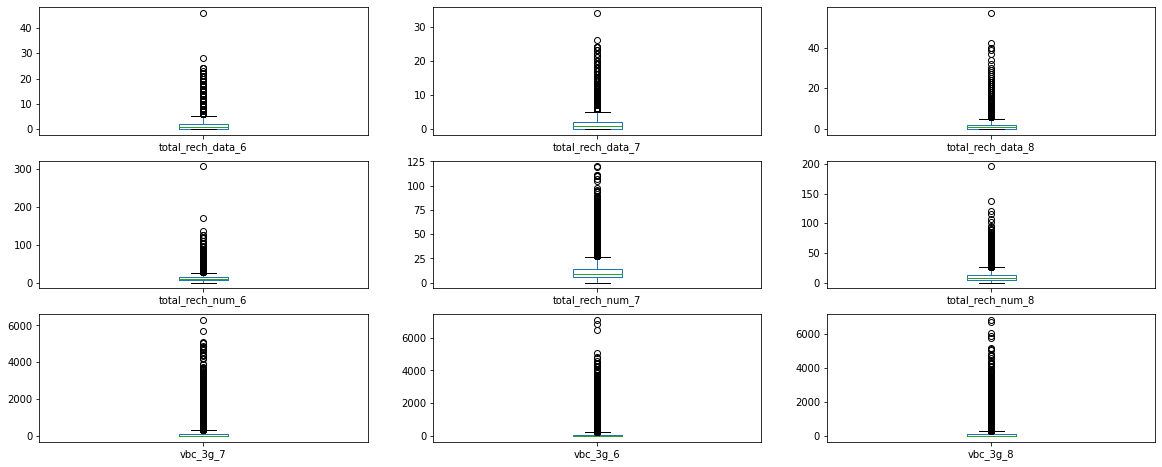

In [305]:
generate_single_box_plts(df_hv, revenue_cols[27:36])

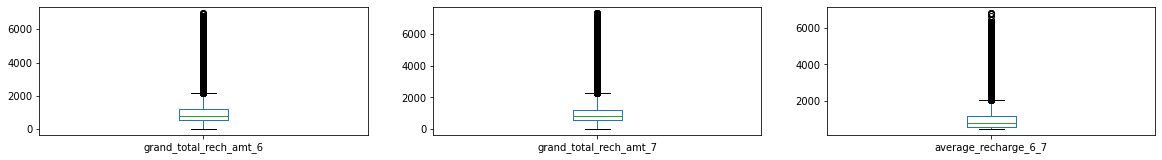

In [306]:
generate_single_box_plts(df_hv, revenue_cols[36:40])

In [307]:
tmp_lst = ['arpu_2g_6',	'arpu_2g_7',	'arpu_2g_8',	'arpu_3g_6',	'arpu_3g_7',	'arpu_3g_8',	'arpu_8',	'max_rech_amt_6',	'max_rech_amt_7',	'max_rech_amt_8',	'max_rech_data_6',	'max_rech_data_7',	'max_rech_data_8',	'total_rech_data_6',	'total_rech_data_7',	'total_rech_data_8',	'vbc_3g_6',]

for col in tmp_lst:
    df_hv = drop_outlier(df_hv, col, 0.0, 0.95)
    
df_hv[revenue_cols].describe(percentiles=[0.25, 0.75, 0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,25%,50%,75%,80%,90%,95%,99%,max
arpu_2g_6,"28,175.00",46.47,100.48,-15.32,0.00,0.00,33.34,65.92,212.17,240.18,442.58,778.00
arpu_2g_7,"28,175.00",46.53,100.53,-15.48,0.00,0.00,31.66,65.73,212.17,233.04,436.17,737.00
arpu_2g_8,"28,175.00",41.77,96.06,-24.43,0.00,0.00,17.07,48.56,196.94,224.00,431.93,672.51
arpu_3g_6,"28,175.00",47.24,108.67,-30.28,0.00,0.00,20.80,63.96,212.17,269.23,490.04,797.95
arpu_3g_7,"28,175.00",47.59,108.77,-26.04,0.00,0.00,21.48,63.96,212.17,268.29,497.33,781.31
arpu_3g_8,"28,175.00",43.73,104.93,-24.49,0.00,0.00,7.43,41.51,212.10,253.07,492.39,717.57
arpu_6,"28,175.00",530.37,337.66,-160.79,306.53,473.79,677.03,742.93,937.87,"1,149.10","1,701.78","3,178.92"
arpu_7,"28,175.00",529.26,334.52,-282.79,305.25,471.59,674.61,738.90,935.68,"1,153.13","1,667.05","3,443.23"
arpu_8,"28,175.00",475.46,356.95,-345.13,226.19,417.92,637.56,704.00,913.67,"1,153.44","1,702.71","3,158.10"
av_rech_amt_data_6,"28,175.00",111.70,143.66,0.00,0.00,42.00,196.00,228.00,304.00,396.30,603.00,"1,006.00"


**Plots for checking churn for the revenue columns**

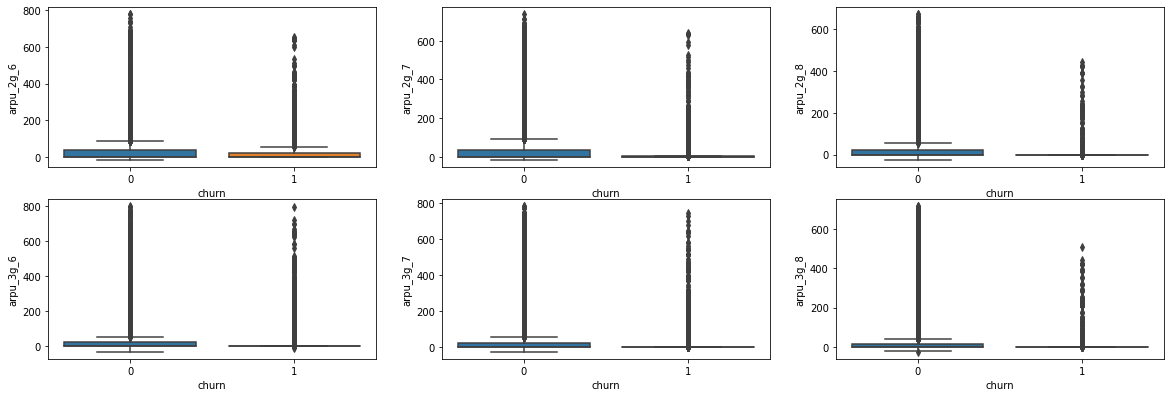

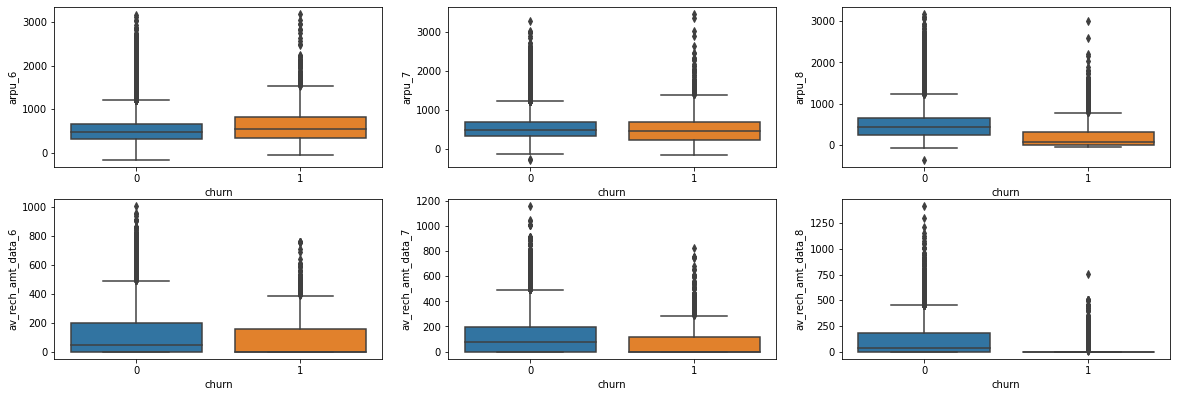

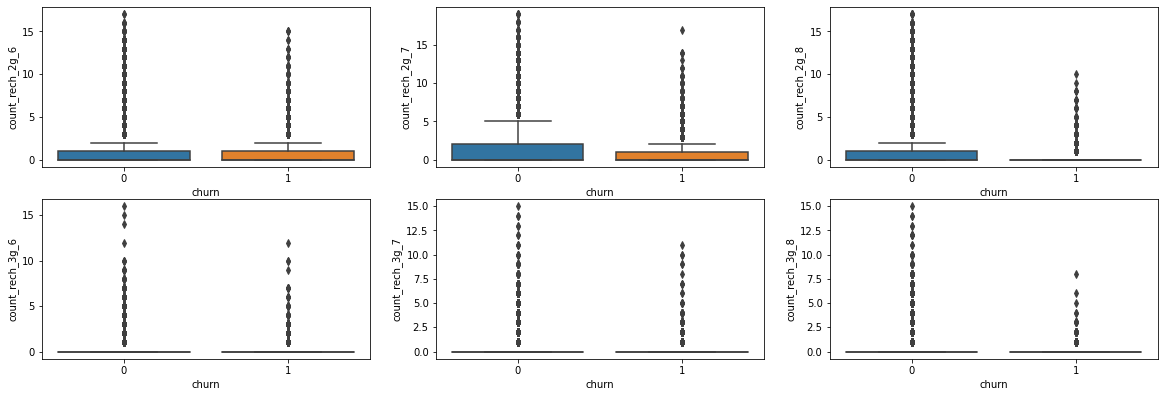

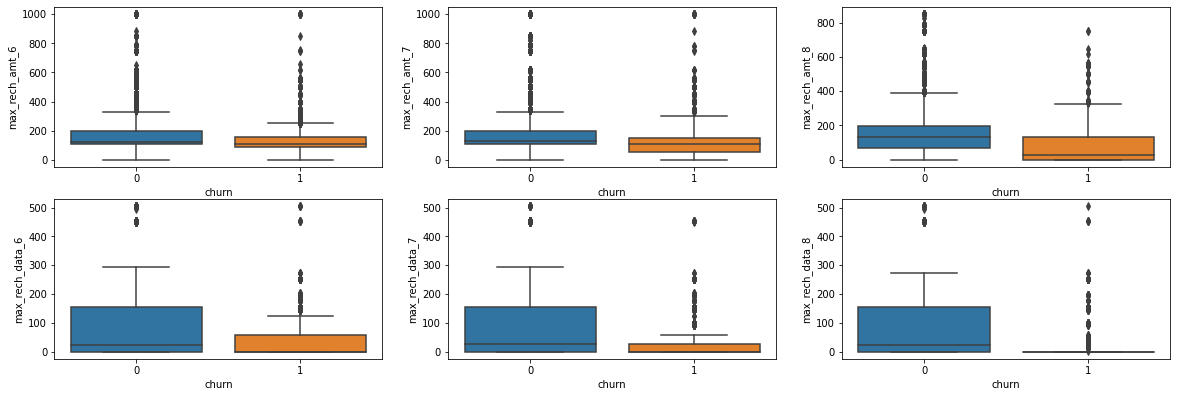

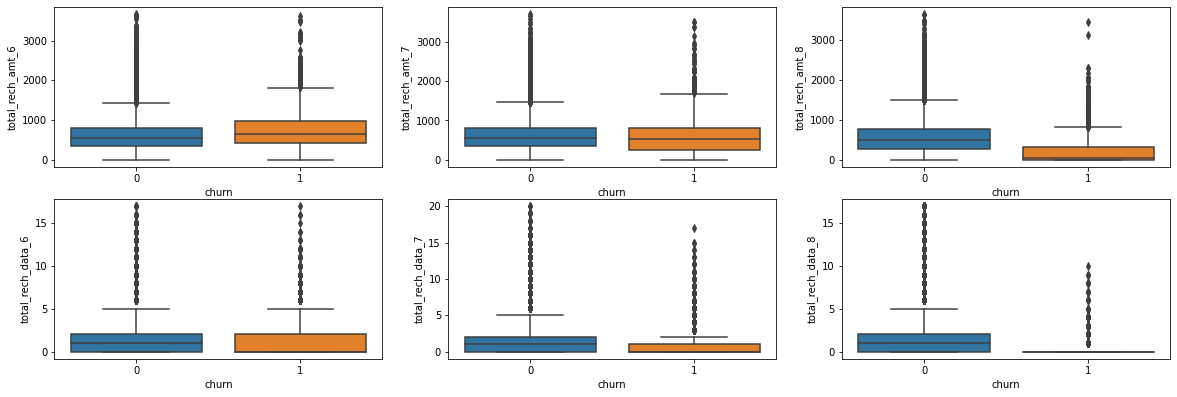

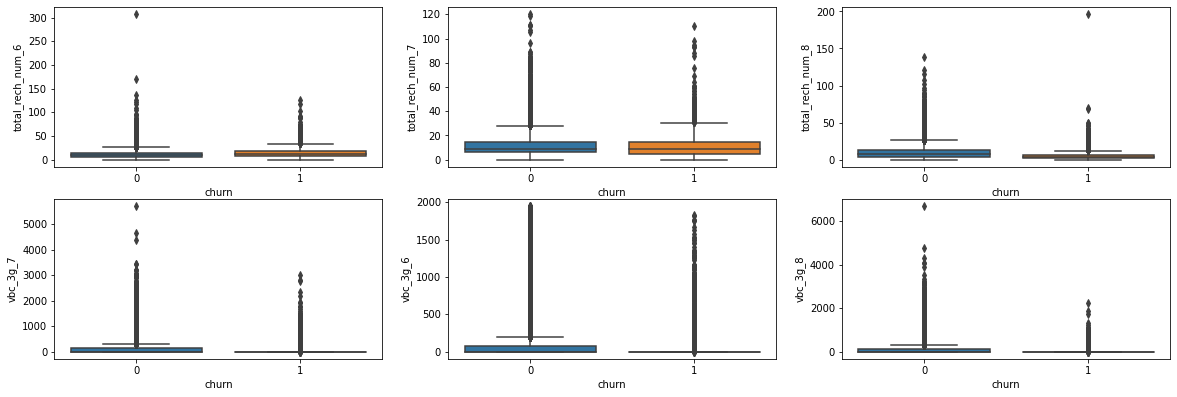

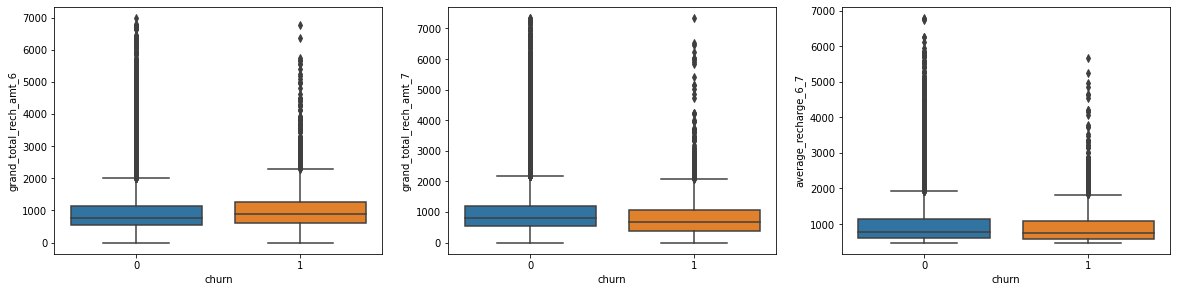

In [308]:
for idx in range(0, int(len(revenue_cols)/6)+1):
    generate_box_plts_y(df_hv, revenue_cols[idx*6 : (idx+1) * 6], 'churn', None, p_fig_size=(20, 10))
    


#### Usage columns analysis 

In [309]:
usage_cols = [
'total_ic_mou_6',
'total_ic_mou_7',
'total_ic_mou_8',
'total_og_mou_6',
'total_og_mou_7',
'total_og_mou_8',
'vol_2g_mb_6',
'vol_2g_mb_7',
'vol_2g_mb_8',
'vol_3g_mb_6',
'vol_3g_mb_7',
'vol_3g_mb_8',
]

In [310]:
df_hv[usage_cols].describe(percentiles=[0.25, 0.75, 0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,25%,50%,75%,80%,90%,95%,99%,max
total_ic_mou_6,"28,175.00",289.37,364.05,0.00,75.37,184.68,369.89,434.99,659.03,910.56,"1,739.65","7,716.14"
total_ic_mou_7,"28,175.00",295.80,370.24,0.00,81.11,188.84,374.86,439.75,665.04,921.57,"1,799.71","7,442.86"
total_ic_mou_8,"28,175.00",278.58,357.87,0.00,63.01,173.69,359.25,424.01,644.20,907.20,"1,709.18","6,066.63"
total_og_mou_6,"28,175.00",613.77,676.05,0.00,124.72,422.28,866.39,"1,004.35","1,447.48","1,903.87","3,143.08","7,597.18"
total_og_mou_7,"28,175.00",632.93,704.45,0.00,123.09,435.81,900.08,"1,037.62","1,487.49","1,947.87","3,249.20","8,224.16"
total_og_mou_8,"28,175.00",550.97,674.57,0.00,76.44,339.59,778.17,911.32,"1,357.52","1,843.76","3,164.36","10,882.86"
vol_2g_mb_6,"28,175.00",124.53,322.90,0.00,0.00,0.00,80.73,143.57,408.66,691.03,"1,491.53","7,755.23"
vol_2g_mb_7,"28,175.00",123.92,325.41,0.00,0.00,0.00,76.46,138.36,401.80,686.48,"1,541.43","7,873.55"
vol_2g_mb_8,"28,175.00",103.95,301.20,0.00,0.00,0.00,48.47,93.09,319.15,610.38,"1,417.81","7,374.19"
vol_3g_mb_6,"28,175.00",250.88,526.24,0.00,0.00,0.00,277.26,459.22,933.92,"1,340.62","2,328.03","7,303.12"


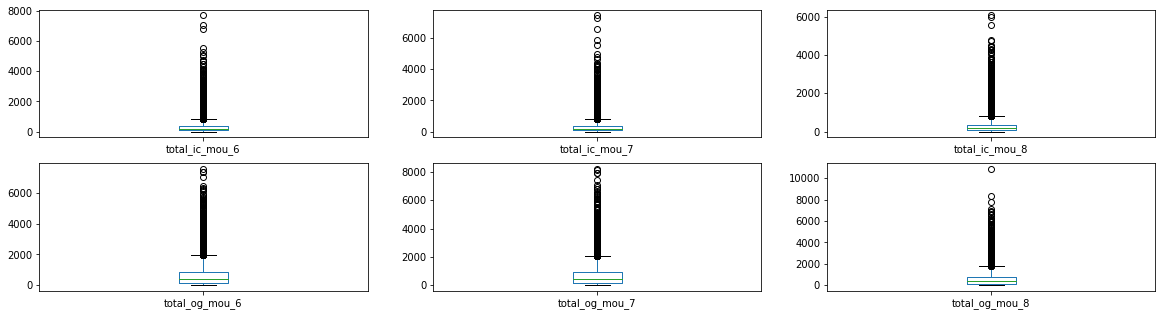

In [311]:
generate_single_box_plts(df_hv, usage_cols[0:6])

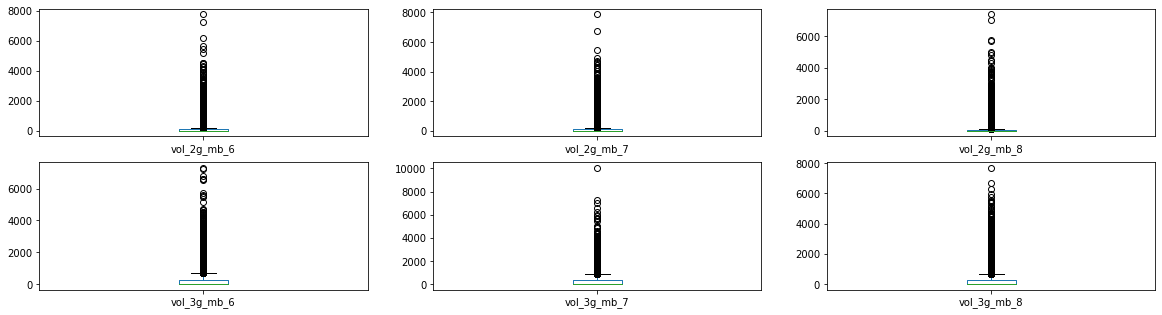

In [312]:
generate_single_box_plts(df_hv, usage_cols[6:12])

**Uptil 95% percentile the usage is gradually increasing. There are a few outliers who are exceptional in usage terms.**

In [313]:
tmp_lst = usage_cols

for col in tmp_lst:
    df_hv = drop_outlier(df_hv, col, 0.0, 0.95)
    
df_hv[usage_cols].describe(percentiles=[0.25, 0.75, 0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,25%,50%,75%,80%,90%,95%,99%,max
total_ic_mou_6,"27,105.00",275.09,297.19,0.00,76.51,185.49,366.43,428.25,639.45,859.89,"1,445.73","2,268.38"
total_ic_mou_7,"27,105.00",279.43,296.55,0.00,81.99,189.08,371.54,433.93,644.97,869.92,"1,456.34","2,230.11"
total_ic_mou_8,"27,105.00",264.30,294.88,0.00,63.76,174.08,356.04,417.49,626.80,861.17,"1,430.28","2,172.34"
total_og_mou_6,"27,105.00",608.00,641.94,0.00,128.33,428.31,867.68,"1,004.39","1,438.18","1,865.57","2,960.75","4,697.04"
total_og_mou_7,"27,105.00",623.56,657.12,0.00,127.04,441.33,899.74,"1,035.04","1,473.62","1,915.68","3,000.94","4,832.53"
total_og_mou_8,"27,105.00",541.20,626.54,0.00,78.66,343.01,778.96,909.84,"1,340.73","1,794.52","2,924.99","4,502.96"
vol_2g_mb_6,"27,105.00",101.30,227.82,0.00,0.00,0.00,69.96,126.33,360.61,601.97,"1,108.36","1,733.78"
vol_2g_mb_7,"27,105.00",97.29,218.89,0.00,0.00,0.00,66.02,119.81,351.44,577.30,"1,072.72","1,616.20"
vol_2g_mb_8,"27,105.00",78.85,191.78,0.00,0.00,0.00,41.89,78.50,272.00,508.27,967.85,"1,379.25"
vol_3g_mb_6,"27,105.00",240.58,484.65,0.00,0.00,0.00,273.13,452.00,916.38,"1,309.28","2,191.81","3,344.40"


**Plots for checking churn for the usage columns**

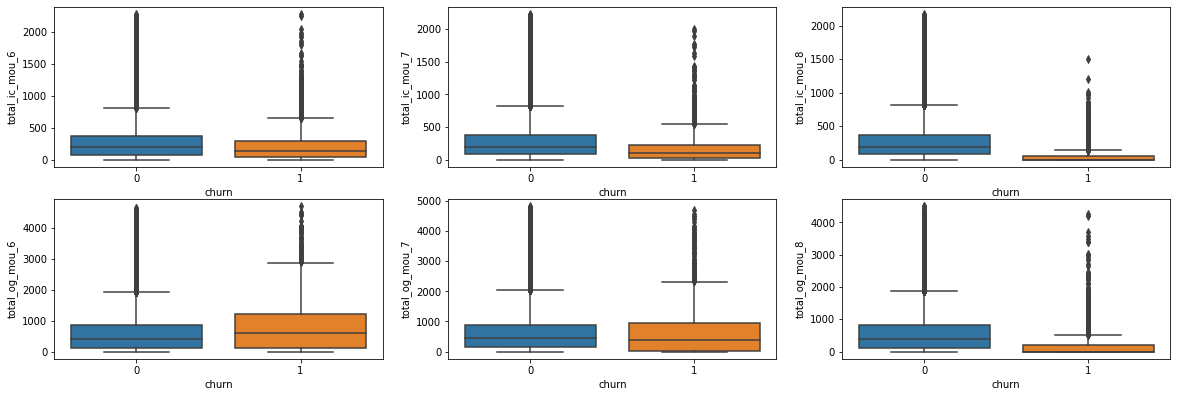

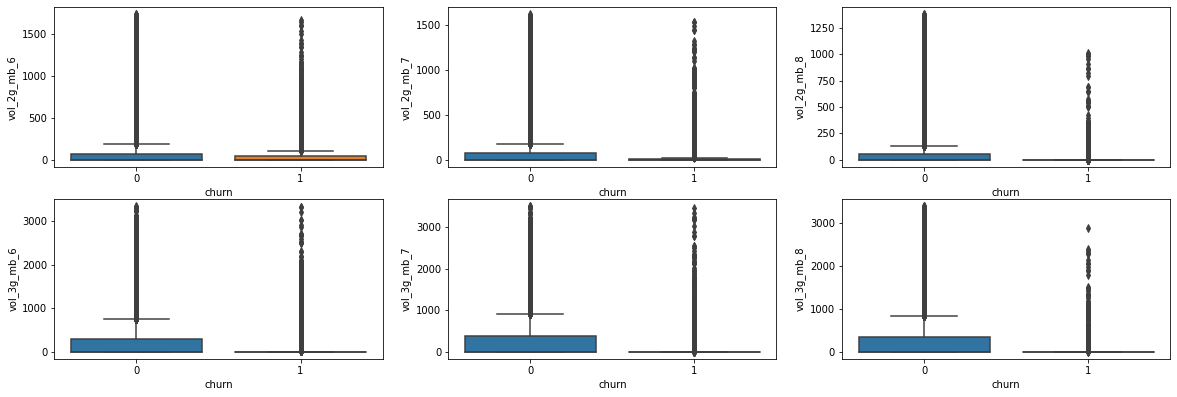

<Figure size 1440x720 with 0 Axes>

In [314]:
for idx in range(0, int(len(usage_cols)/6)+1):
    generate_box_plts_y(df_hv, usage_cols[idx*6 : (idx+1) * 6], 'churn', None, p_fig_size=(20, 10))

### Bivariate analysis

In [315]:
mnth_6_cols = df_hv.columns[df_hv.columns.str.contains('_6')]
mnth_6_cols = mnth_6_cols.to_list()

mnth_7_cols = df_hv.columns[df_hv.columns.str.contains('_7')]
mnth_7_cols = mnth_7_cols.to_list()

mnth_8_cols = df_hv.columns[df_hv.columns.str.contains('_8')]
mnth_8_cols = mnth_8_cols.to_list()

In [316]:
oth_lst = list(set(df_hv.columns.to_list()) - set(mnth_6_cols) - set(mnth_7_cols) - set(mnth_8_cols))
oth_lst

['mobile_number',
 'churn',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'aon',
 'aon_yrs',
 'circle_id',
 'loc_ic_t2o_mou']

In [317]:
mnth_6_cols.extend(['churn', 'aon'])
mnth_7_cols.extend(['churn', 'aon'])
mnth_8_cols.extend(['churn', 'aon'])

In [318]:
cmap = sns.diverging_palette(20, 230, as_cmap=True)

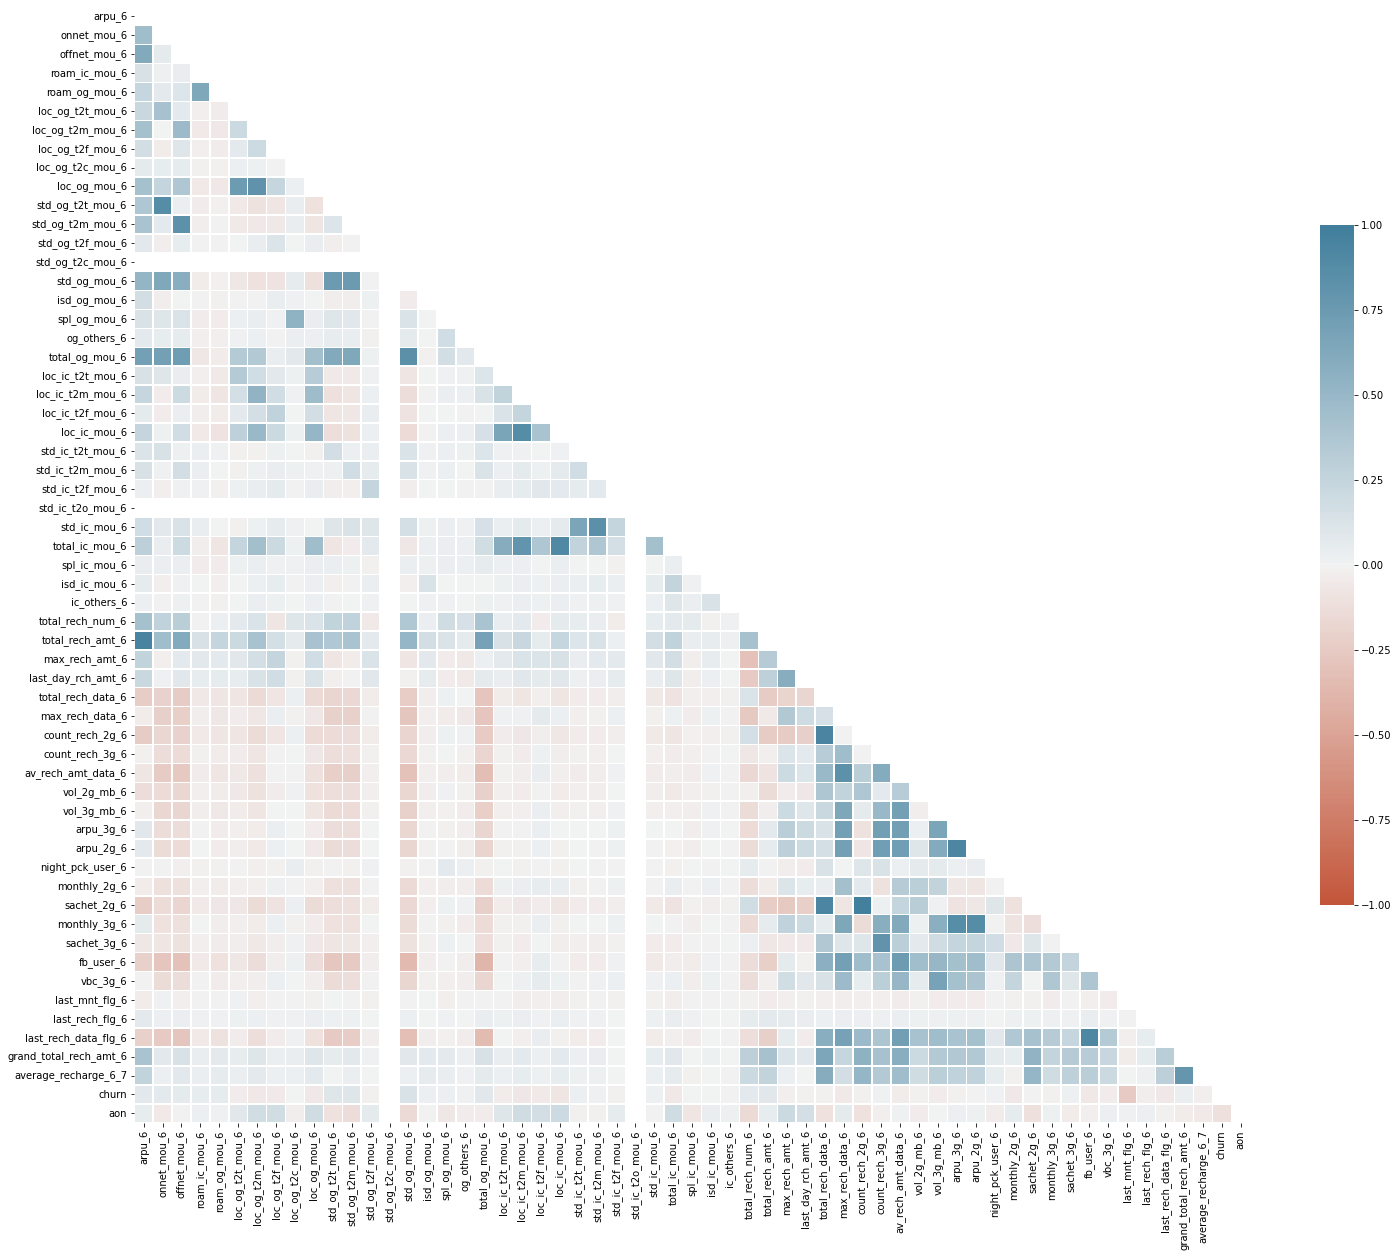

In [319]:
mnth_corr_6 = df_hv[mnth_6_cols].corr()
mask = np.triu(np.ones_like(mnth_corr_6, dtype=bool))

plt.figure(figsize=(25, 25))
sns.heatmap(mnth_corr_6, mask=mask, cmap=cmap, vmin=-1, vmax=1,  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

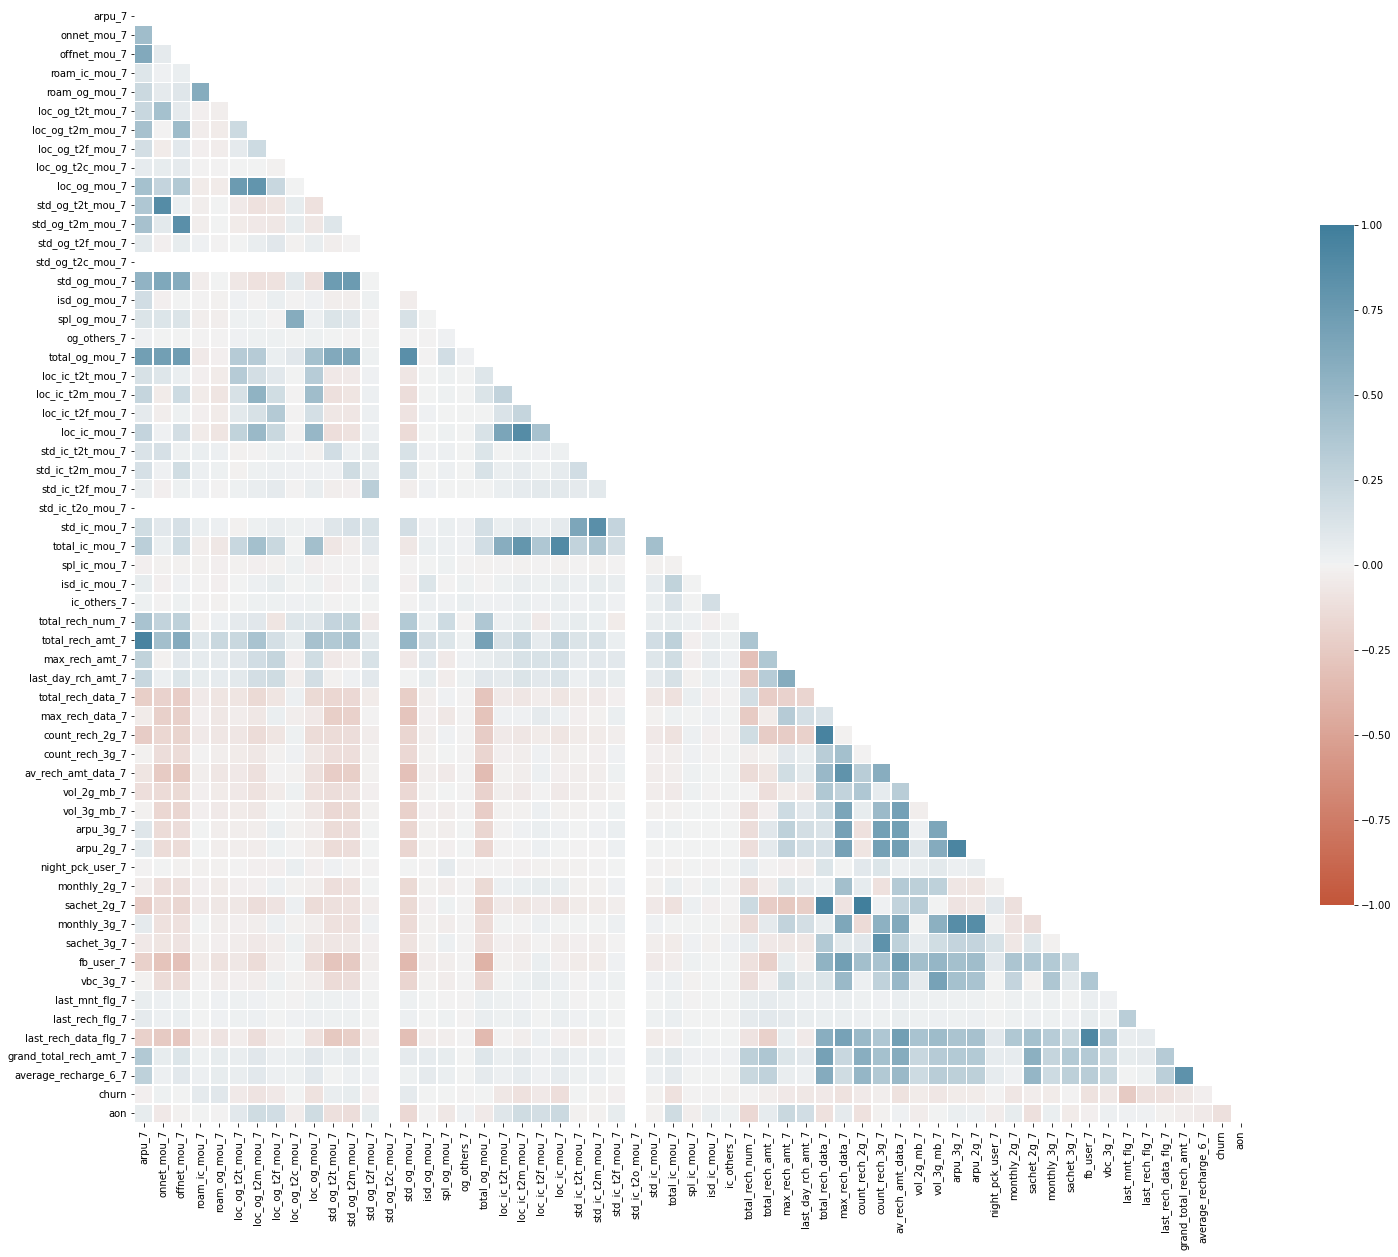

In [320]:
mnth_corr_7 = df_hv[mnth_7_cols].corr()
mask = np.triu(np.ones_like(mnth_corr_7, dtype=bool))


plt.figure(figsize=(25, 25))
sns.heatmap(mnth_corr_7, mask=mask, cmap=cmap, vmin=-1, vmax=1,  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

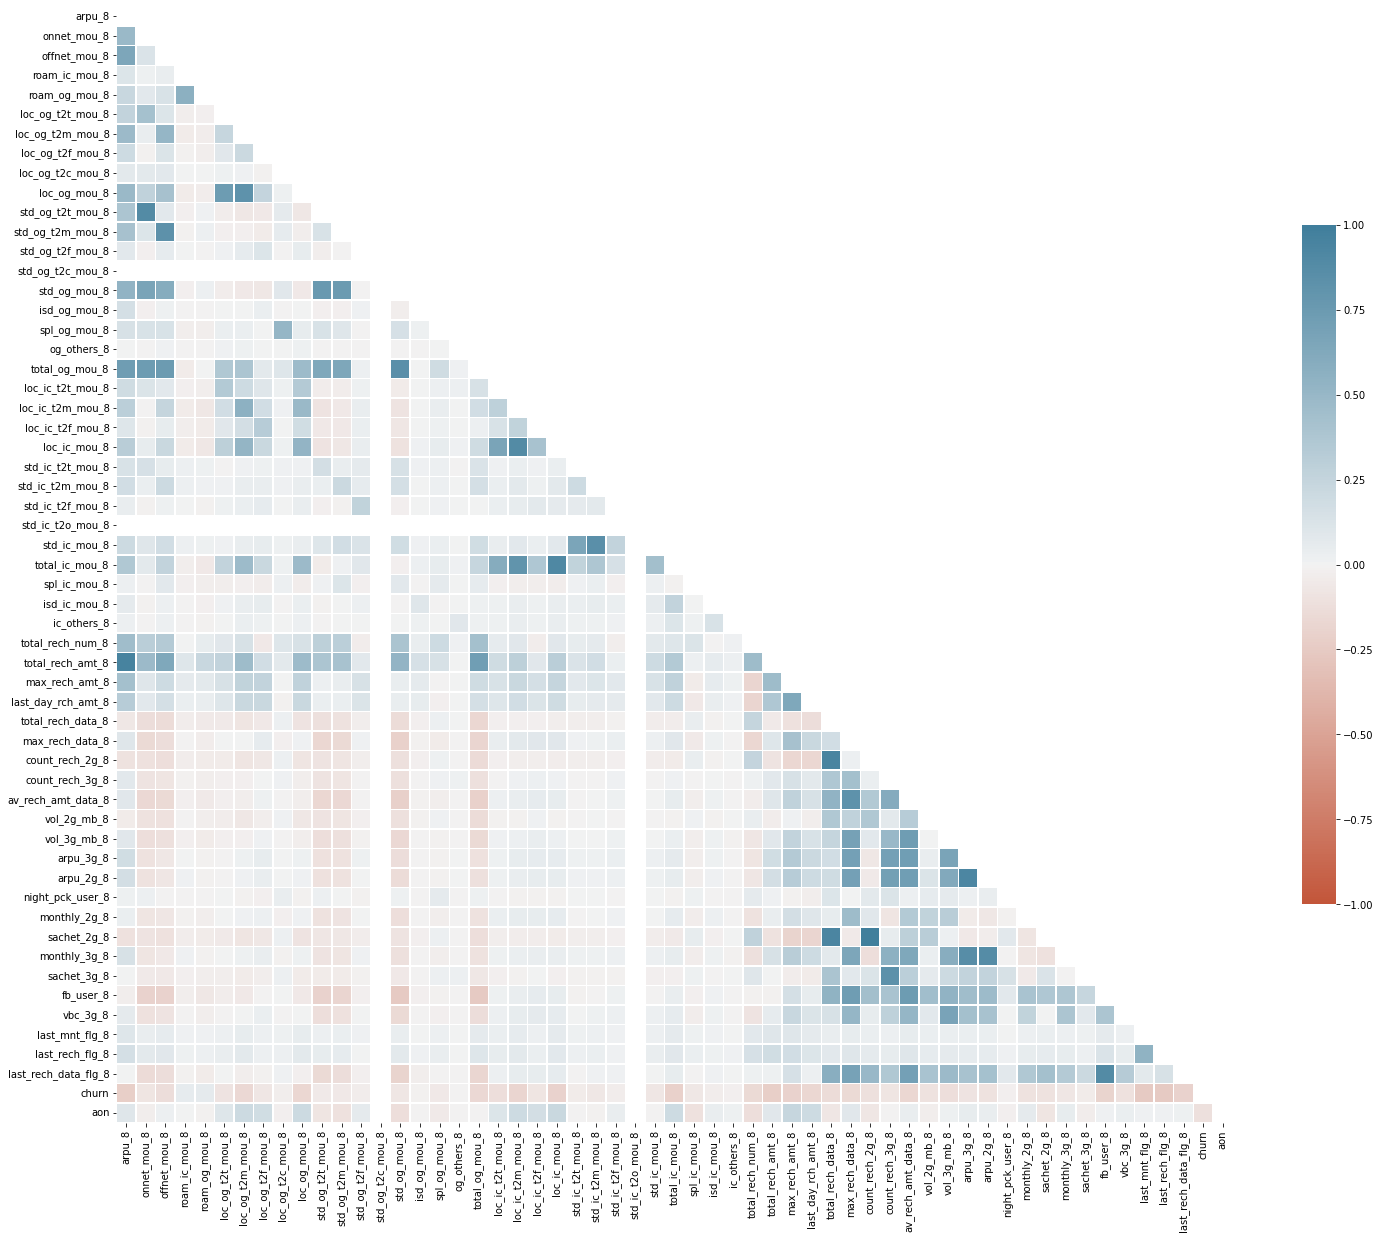

In [321]:
mnth_corr_8 = df_hv[mnth_8_cols].corr()
mask = np.triu(np.ones_like(mnth_corr_8, dtype=bool))

plt.figure(figsize=(25, 25))
sns.heatmap(mnth_corr_8, mask=mask, cmap=cmap, vmin=-1, vmax=1,  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## EDA Analysis Results

>- circle_id: Only one value. So all customers belong to 1 circle. Drop column
>- 'loc_ic_t2o_mou', 'loc_og_t2o_mou', 'std_og_t2o_mou': 
>- fb_users: Lower churn % among those who use fb_user pack
>- monthly_2g: Of the different services available, service 4 has highest churn in month 6 while service 0 has highest churn in month 7 & 8
>- monthly_3g: Of the different services available, service 5 has highest churn in month 6 while service 0 has highest churn in month 7 & 8
>- night_pck_user: Month 6 shows higher % of churn while the 7 & 8 months show lower churn %
>- sachet_2g: sachet 34 has highest % of churn in month 6, while in 7 its sachet 42 and in 8 its 20. Higher sachet value users tend to have higher churn %
>- sachet_3g: Higher the sachet value, higher the churn %
>- aon_yrs: Churn reduces with every year that the customer spends on the network. This obvious because mobile number is shared with contacts and used for reference in accounts etc. Churn % drops significantly after the 3rd year 
>- last_rech_data: Of the people who do recharge monthly, the % of churn is low 
>- last_rech:  Of the people who do recharge monthly, the % of churn is low 

>- av_rech_amt_data: Higher the average amount of recharge for data, lower the churn
>- total_rech_amt: Higher the amount of recharge, lower the churn

>- arpu: total_og has a high positive impact on arpu. So customers who make outgoing calls generate higher revenue. total_ic comparatively has lower impact on revenue, possibly because some people only expect to receive calls. std also has a higher positive impact but roam does not impact much, indicating that maybe prepaid users do not roam much or do not use roaming services since its expensive

>- sachet_2g/sachet_3g: High correlation observed between recharges and sachets indicating that customers prefer to recharge using sachet. Possibly the circle is in a low income area where customers buy service as an when they need

>- fb_user: FB users do not make as many outgoing calls as others. They tend to recharge data or use sachet's 

>- vbc_3g: Some corelation is seen between volume based cost scheme and data usages. Seems like volume based is prefered for data users 

## Drop Columns

In [322]:
col_to_drop = ['circle_id',
'loc_ic_t2o_mou',
'loc_og_t2o_mou',
'mobile_number',
'std_og_t2o_mou',
'aon'
]

df_hv = df_hv.drop(col_to_drop, axis=1)

df_hv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27105 entries, 0 to 99997
Columns: 179 entries, last_date_of_month_6 to aon_yrs
dtypes: category(1), datetime64[ns](9), float64(135), int64(34)
memory usage: 38.3 MB


## PCA

In [323]:
## dummies - monthly and satchet
dummy_col=['monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6',
           'monthly_2g_7', 'sachet_2g_7', 'monthly_3g_7', 'sachet_3g_7',
           'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8',
           'aon_yrs'
           ]

In [324]:
df_hv[dummy_col].describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_2g_6,"27,105.00",0.16,0.41,0.00,0.00,0.00,0.00,3.00
sachet_2g_6,"27,105.00",1.02,2.27,0.00,0.00,0.00,1.00,17.00
monthly_3g_6,"27,105.00",0.17,0.46,0.00,0.00,0.00,0.00,5.00
sachet_3g_6,"27,105.00",0.16,0.63,0.00,0.00,0.00,0.00,16.00
monthly_2g_7,"27,105.00",0.17,0.43,0.00,0.00,0.00,0.00,4.00
sachet_2g_7,"27,105.00",1.16,2.47,0.00,0.00,0.00,1.00,19.00
monthly_3g_7,"27,105.00",0.17,0.47,0.00,0.00,0.00,0.00,4.00
sachet_3g_7,"27,105.00",0.17,0.69,0.00,0.00,0.00,0.00,14.00
monthly_2g_8,"27,105.00",0.14,0.38,0.00,0.00,0.00,0.00,4.00
sachet_2g_8,"27,105.00",1.00,2.25,0.00,0.00,0.00,1.00,17.00


In [325]:
for x in dummy_col:
  df_hv[x] = df_hv[x].astype('object')
df_hv[dummy_col].describe().T

,count,unique,top,freq
monthly_2g_6,27105,4,0,23128
sachet_2g_6,27105,18,0,19134
monthly_3g_6,27105,6,0,23489
sachet_3g_6,27105,13,0,24323
monthly_2g_7,27105,5,0,23006
sachet_2g_7,27105,20,0,18893
monthly_3g_7,27105,5,0,23452
sachet_3g_7,27105,14,0,24388
monthly_2g_8,27105,5,0,23541
sachet_2g_8,27105,18,0,19334


In [326]:
df_dummies = pd.get_dummies(df_hv[dummy_col],drop_first = True)
df_dummies.head()

,monthly_2g_6_1,monthly_2g_6_2,monthly_2g_6_3,sachet_2g_6_1,sachet_2g_6_2,sachet_2g_6_3,sachet_2g_6_4,sachet_2g_6_5,sachet_2g_6_6,sachet_2g_6_7,sachet_2g_6_8,sachet_2g_6_9,sachet_2g_6_10,sachet_2g_6_11,sachet_2g_6_12,sachet_2g_6_13,sachet_2g_6_14,sachet_2g_6_15,sachet_2g_6_16,sachet_2g_6_17,monthly_3g_6_1,monthly_3g_6_2,monthly_3g_6_3,monthly_3g_6_4,monthly_3g_6_5,sachet_3g_6_1,sachet_3g_6_2,sachet_3g_6_3,sachet_3g_6_4,sachet_3g_6_5,sachet_3g_6_6,sachet_3g_6_7,sachet_3g_6_8,sachet_3g_6_9,sachet_3g_6_10,sachet_3g_6_12,sachet_3g_6_16,monthly_2g_7_1,monthly_2g_7_2,monthly_2g_7_3,...,sachet_2g_8_8,sachet_2g_8_9,sachet_2g_8_10,sachet_2g_8_11,sachet_2g_8_12,sachet_2g_8_13,sachet_2g_8_14,sachet_2g_8_15,sachet_2g_8_16,sachet_2g_8_17,monthly_3g_8_1,monthly_3g_8_2,monthly_3g_8_3,monthly_3g_8_4,sachet_3g_8_1,sachet_3g_8_2,sachet_3g_8_3,sachet_3g_8_4,sachet_3g_8_5,sachet_3g_8_6,sachet_3g_8_7,sachet_3g_8_8,sachet_3g_8_9,sachet_3g_8_10,sachet_3g_8_11,sachet_3g_8_12,sachet_3g_8_13,sachet_3g_8_14,sachet_3g_8_15,aon_yrs_2,aon_yrs_3,aon_yrs_4,aon_yrs_5,aon_yrs_6,aon_yrs_7,aon_yrs_8,aon_yrs_9,aon_yrs_10,aon_yrs_11,aon_yrs_12
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [327]:
df_hv.drop(dummy_col,axis=1,inplace=True)
df_hv=pd.concat([df_hv,df_dummies], axis=1)
df_hv.shape

(27105, 294)

In [328]:
#list(df_hv.columns)

In [329]:
df_hv.columns[df_hv.columns.str.contains('flg')]

Index(['last_mnt_flg_6', 'last_mnt_flg_7', 'last_mnt_flg_8', 'last_rech_flg_6',
       'last_rech_flg_7', 'last_rech_flg_8', 'last_rech_data_flg_6',
       'last_rech_data_flg_7', 'last_rech_data_flg_8'],
      dtype='object')

In [330]:
date_data=['last_date_of_month_6','date_of_last_rech_data_6','date_of_last_rech_6',
                    'last_date_of_month_7','date_of_last_rech_data_7','date_of_last_rech_7',
                    'last_date_of_month_8','date_of_last_rech_data_8','date_of_last_rech_8',
                    ]
df_hv = df_hv.drop(date_data, axis=1)

In [331]:
date_flg = ['last_mnt_flg_6', 'last_mnt_flg_7', 'last_mnt_flg_8', 'last_rech_flg_6',
       'last_rech_flg_7', 'last_rech_flg_8', 'last_rech_data_flg_6',
       'last_rech_data_flg_7', 'last_rech_data_flg_8']

df_hv = df_hv.drop(date_flg, axis=1)

In [332]:
df_hv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27105 entries, 0 to 99997
Columns: 276 entries, arpu_6 to aon_yrs_12
dtypes: float64(135), int64(13), uint8(128)
memory usage: 35.4 MB


In [333]:
missing_values(df_hv)

,percent_missing


### Train Test Split

In [334]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [335]:
# Separate input features and target
y = df_hv.churn
X = df_hv.drop('churn', axis=1)

In [336]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

old_churn_rate = (sum(y_train==1)/len(y_train)) * 100


sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)

new_churn_rate = (sum(y_train==1)/len(y_train)) * 100

print('new_churn_rate', new_churn_rate, 'old_churn_rate', old_churn_rate)

new_churn_rate 50.0 old_churn_rate 8.05293191656828


In [337]:
print(X_train.shape, y_train.shape)

(37382, 275) (37382,)


In [338]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [339]:
X_train_int = X_train.select_dtypes('int64')
X_train_float = X_train.select_dtypes('float64')

In [340]:
X_train_int.columns

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8'],
      dtype='object')

In [341]:
X_train_float.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'vbc_3g_8',
       'vbc_3g_7', 'vbc_3g_6', 'grand_total_rech_amt_6',
       'grand_total_rech_amt_7', 'average_recharge_6_7'],
      dtype='object', length=135)

In [342]:
numeric_col=list(X_train_int.columns)+list(X_train_float.columns)
len(numeric_col)

147

In [343]:
X_train[numeric_col] = scaler.fit_transform(X_train[numeric_col])
X_test[numeric_col] = scaler.transform(X_test[numeric_col])

In [344]:
X_train[numeric_col].describe().T

,count,mean,std,min,25%,50%,75%,max
total_rech_num_6,"37,382.00",-0.00,1.00,-1.32,-0.59,-0.18,0.33,16.20
total_rech_num_7,"37,382.00",-0.00,1.00,-1.28,-0.61,-0.27,0.41,12.30
total_rech_num_8,"37,382.00",0.00,1.00,-0.92,-0.67,-0.31,0.30,23.00
total_rech_amt_6,"37,382.00",-0.00,1.00,-1.57,-0.68,-0.16,0.48,7.06
total_rech_amt_7,"37,382.00",-0.00,1.00,-1.46,-0.71,-0.13,0.49,7.22
...,...,...,...,...,...,...,...,...
vbc_3g_7,"37,382.00",0.00,1.00,-0.38,-0.38,-0.38,-0.25,10.68
vbc_3g_6,"37,382.00",0.00,1.00,-0.40,-0.40,-0.40,-0.27,7.40
grand_total_rech_amt_6,"37,382.00",-0.00,1.00,-1.37,-0.58,-0.24,0.25,8.19
grand_total_rech_amt_7,"37,382.00",0.00,1.00,-1.22,-0.54,-0.23,0.27,8.82


In [345]:
from sklearn.decomposition import PCA

In [346]:
pca = PCA(0.80)

In [347]:
X_train_pca = pca.fit_transform(X_train)

In [348]:
np.any(np.isnan(X_train_pca))

False

In [349]:
np.all(np.isfinite(X_train_pca))

True

In [350]:
X_train_pca.shape

(37382, 36)

In [351]:
X_train.shape

(37382, 275)

In [352]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

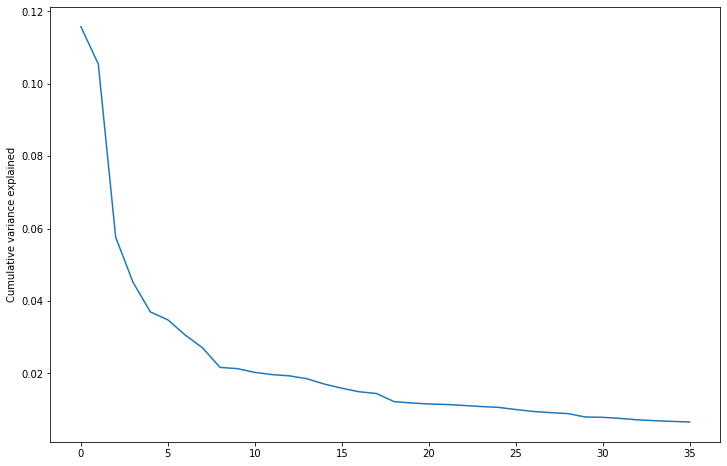

In [353]:
fig = plt.figure(figsize=[12,8])
plt.plot(pca.explained_variance_ratio_)
plt.ylabel("Cumulative variance explained")
plt.show()

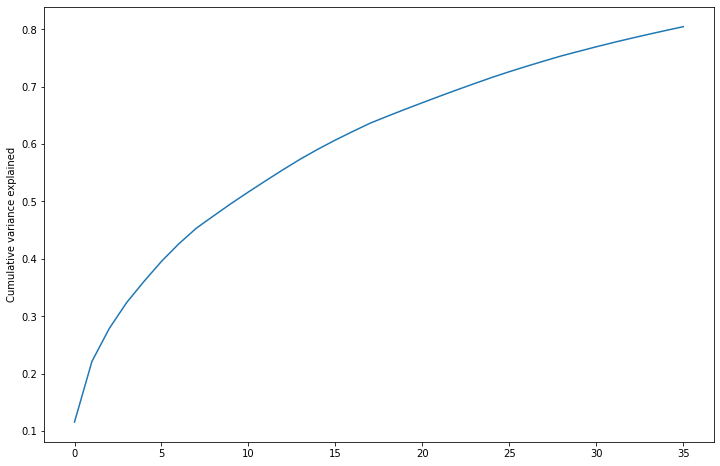

In [354]:
fig = plt.figure(figsize=[12,8])
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

## Build Model

In [355]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

### Basic RF Model

In [356]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [357]:
rf.fit(X_train_pca, y_train)
y_train_pred = rf.predict(X_train_pca)
print(round(metrics.recall_score(y_train, y_train_pred)*100, 2), round(metrics.accuracy_score(y_train, y_train_pred)))

100.0 1


In [358]:
X_test_pca = pca.transform(X_test)
y_test_pred = rf.predict(X_test_pca)
print('Recall:', round(metrics.recall_score(y_test, y_test_pred)*100, 2), 'Accuracy:', round(metrics.accuracy_score(y_test, y_test_pred)))

Recall: 58.36 Accuracy: 1


### Random Forrest Hyperparameter tuning

**THE FOLLOWING IS COMMENTED SINCE IT TAKES A LOT OF TIME TO EXECUTE. IT WAS USED TO FIND THE PARAMETERS AND THEN THE MODULE WAS TUNED MANUALLY**

In [359]:
#rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [360]:
# params = {
#     'max_depth': [30, 40, 50, 60, 70],
#     'min_samples_leaf': [20, 40, 60, 80],
#     'n_estimators': [100, 150, 200],
#     'max_features': [30, 50, 60]
# }

In [361]:
# grid_search = GridSearchCV(estimator=rf,
#                            param_grid=params,
#                            cv = 5,
#                            n_jobs=4, verbose=1, scoring="recall")


# grid_search = RandomizedSearchCV(estimator=rf,
#                            param_distributions=params,
#                            cv = 5,
#                            n_jobs=2, verbose=1, scoring="recall")

In [362]:
# %%time
# grid_search.fit(X_train_pca, y_train)

In [363]:
#grid_search.best_params_

In [364]:
# rf_best = grid_search.best_estimator_
# rf_best

In [365]:
# rf_best.fit(X_train_pca, y_train)
# y_train_pred = rf_best.predict(X_train_pca)
# print('Recall', round(metrics.recall_score(y_train, y_train_pred)*100, 2), 'Accuracy', round(metrics.accuracy_score(y_train, y_train_pred)))

In [366]:
# X_test_pca = pca.transform(X_test)
# y_test_pred = rf_best.predict(X_test_pca)
# print('Recall', round(metrics.recall_score(y_test, y_test_pred)*100, 2), 'Accuracy', round(metrics.accuracy_score(y_test, y_test_pred)))

In [367]:
from sklearn.metrics import plot_roc_curve

In [368]:
# plot_roc_curve(rf_best, X_test_pca, y_test, drop_intermediate=False)
# plt.show()

### Manual RF Tuning

In [369]:
rf_best = RandomForestClassifier(
    n_estimators=50,
    min_samples_leaf=60,
    max_features=20,
    max_depth=20,              
    n_jobs=-1, random_state=42)

rf_best.fit(X_train_pca, y_train)
y_train_pred = rf_best.predict(X_train_pca)
#print('Recall', round(metrics.recall_score(y_train, y_train_pred)*100, 2), 'Accuracy', round(metrics.accuracy_score(y_train, y_train_pred)))

X_test_pca = pca.transform(X_test)
y_test_pred = rf_best.predict(X_test_pca)
#print('Recall', round(metrics.recall_score(y_test, y_test_pred)*100, 2), 'Accuracy', round(metrics.accuracy_score(y_test, y_test_pred)))

print('Recall', round(metrics.recall_score(y_train, y_train_pred)*100, 2), '|', round(metrics.recall_score(y_test, y_test_pred)*100, 2))
print('Accuracy', round(metrics.accuracy_score(y_train, y_train_pred)), round(metrics.accuracy_score(y_test, y_test_pred)))


Recall 88.12 | 76.36
Accuracy 1 1


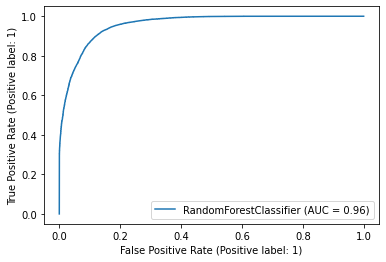

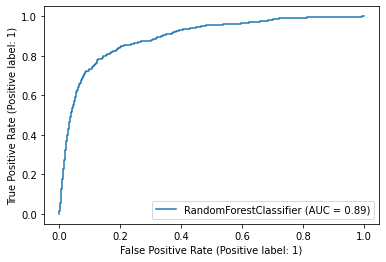

In [370]:
plot_roc_curve(rf_best, X_train_pca, y_train)
plot_roc_curve(rf_best, X_test_pca, y_test)

### XGBoost Model

In [371]:
from xgboost import XGBClassifier

In [372]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_pca, y_train)
y_train_pred = xgb.predict(X_train_pca)
#print(round(metrics.recall_score(y_train, y_train_pred)*100, 2), round(metrics.accuracy_score(y_train, y_train_pred)))

X_test_pca = pca.transform(X_test)
y_test_pred = xgb.predict(X_test_pca)
#print('Recall:', round(metrics.recall_score(y_test, y_test_pred)*100, 2), 'Accuracy:', round(metrics.accuracy_score(y_test, y_test_pred)))

print(round(metrics.recall_score(y_train, y_train_pred)*100, 2), '|', round(metrics.recall_score(y_test, y_test_pred)*100, 2))

86.14 | 79.82


In [373]:
# Parameters manually tweaked
xgb = XGBClassifier(random_state=42, 
        n_estimators=100,
        learning_rate=0.1,
        min_child_weight=7,
        gamma=20,
        subsample=0.8,
        colsample_bytree= 0.8,
        max_depth=3)

xgb.fit(X_train_pca, y_train)
y_train_pred = xgb.predict(X_train_pca)
#print(round(metrics.recall_score(y_train, y_train_pred)*100, 2), round(metrics.accuracy_score(y_train, y_train_pred)))

X_test_pca = pca.transform(X_test)
y_test_pred = xgb.predict(X_test_pca)
#print('Recall:', round(metrics.recall_score(y_test, y_test_pred)*100, 2), 'Accuracy:', round(metrics.accuracy_score(y_test, y_test_pred)))

print(round(metrics.recall_score(y_train, y_train_pred)*100, 2), '|', round(metrics.recall_score(y_test, y_test_pred)*100, 2))

85.91 | 78.73


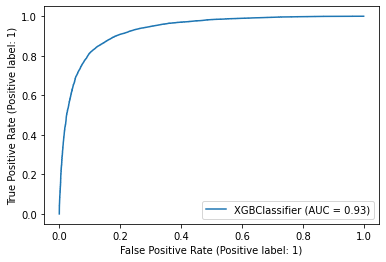

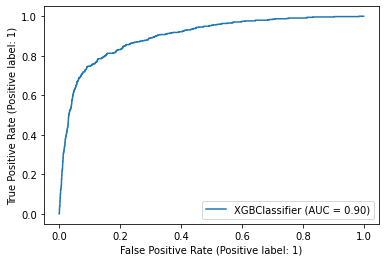

In [374]:
plot_roc_curve(xgb, X_train_pca, y_train)
plot_roc_curve(xgb, X_test_pca, y_test)

## Model Evaluation Results

**Class Imbalance**
>- Since the churn % is lesser considered to the not churn %, SMOTE was used to reduce the imbalance.
>- Training churn rate thus was increased from 8% to 50% solving the imbalance problem

**PCA**
>- By manipulating PCA parameter, the number of features can be controlled. 
>- -PCA=0.95 Features=79
>- -PCA=0.9 Features= 56
>- -PCA=0.8 Features= 36
>- -PCA=0.7 Features= 24
>- Modelling was tried with different PCA values. Higher performance was observed with lower PCA, i.e., with fewer features, the model performance was better. 
>- Thus PCA=0.7 was chosen

**Random Forrest**
>- The modelling using GridSearchCV takes hours hence has been commented out. Parameters have been derived using RandomSearch and Manual tuning of hyper paramters
>- Recall: Train - 88.12   Test - 76.36

**XGBoost**
>- Recall: Train - 82.14   Test - 79.82

**Chosen Model**
>- XGBoost performs better and looks to be more stable than since the train and test are closer 

## Derive Feature Importance

### Logistic Regression for feature importance

In [375]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix

In [376]:
def vif():
    vif = pd.DataFrame()
    vif['Features'] = X_train[col].columns
    vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [377]:
logreg = LogisticRegression()

In [378]:
rfe = RFE(estimator=logreg, n_features_to_select=50)          
rfe = rfe.fit(X_train, y_train) 

In [379]:
#list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [380]:
col = X_train.columns[rfe.support_]

In [381]:

X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37331
Model Family:                Binomial   Df Model:                           50
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11034.
Date:                Wed, 24 Nov 2021   Deviance:                       22069.
Time:                        17:27:29   Pearson chi2:                 1.68e+05
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9325      0.030     64.777      0.000       1.874       1.991
loc_ic_mou_8      -1.6111      0.035    -46.184      0.000      -1.680      -1.543
monthly_2g_6_1    -1.3573      0.102    -13.294      0.000      -1.557      -1.157
monthly_2g_6_2    -2.1363      0.357     -5.987      0.000      -2.836      -1.437
sachet_2g_6_1     -1.0944      0.085    -12.944      0.000      -1.260      -0.929
sachet_2g_6_2     -1.1378      0.134     -8.487      0.000      -1.401      -0.875
sachet_2g_6_10    -1.0966      0.510     -2.149      0.032      -2.097      -0.097
sachet_2g_6_16   -27.8937   1.61e+05     -0.000      1.000   -3.15e+05    3.15e+05
sachet_3g_6_2     -1.3301      0.281     -4.728      0.000      -1.882      -0.779
sachet_3g_6_7     -1.4506      1.155     -1.256      0.209      -3.715       0.814
monthly_2g_7_2    -1.9834      0.435     -4.559      0.000      -2.836      -1.131
sachet_2g_7_11    -1.0566      0.566     -1.866      0.062      -2.166       0.053
sachet_2g_7_12    -2.5063      0.894     -2.804      0.005      -4.258      -0.755
sachet_2g_7_13   -26.9855   7.61e+04     -0.000      1.000   -1.49e+05    1.49e+05
monthly_3g_7_3    -2.0471      0.737     -2.779      0.005      -3.491      -0.603
monthly_3g_7_4   -27.2984   1.29e+05     -0.000      1.000   -2.53e+05    2.53e+05
monthly_2g_8_1    -2.8871      0.155    -18.601      0.000      -3.191      -2.583
monthly_2g_8_2   -26.4780   3.28e+04     -0.001      0.999   -6.42e+04    6.42e+04
sachet_2g_8_1     -1.4428      0.085    -16.949      0.000      -1.610      -1.276
sachet_2g_8_2     -2.1958      0.144    -15.246      0.000      -2.478      -1.913
sachet_2g_8_3     -3.7462      0.291    -12.871      0.000      -4.317      -3.176
sachet_2g_8_4     -3.3844      0.273    -12.418      0.000      -3.919      -2.850
sachet_2g_8_5     -4.3704      0.432    -10.110      0.000      -5.218      -3.523
sachet_2g_8_6     -3.6589      0.385     -9.515      0.000      -4.413      -2.905
sachet_2g_8_7     -5.0968      0.731     -6.973      0.000      -6.529      -3.664
sachet_2g_8_8    -27.4808   3.42e+04     -0.001      0.999   -6.71e+04     6.7e+04
sachet_2g_8_9     -5.2574      1.025     -5.131      0.000      -7.266      -3.249
sachet_2g_8_10   -27.4390   4.27e+04     -0.001      0.999   -8.37e+04    8.36e+04
sachet_2g_8_11   -27.7530   4.81e+04     -0.001      1.000   -9.44e+04    9.43e+04
sachet_2g_8_12   -27.4841   6.48e+04     -0.000      1.000   -1.27e+05    1.27e+05
sachet_2g_8_14   -28.0160   8.66e+04     -0.000      1.000    -1.7e+05     1.7e+05
monthly_3g_8_1    -2.6938      0.101    -26.720      0.000      -2.891      -2.496
monthly_3g_8_2    -2.7941      0.204    -13.723      0.000      -3.193      -2.395
monthly_3g_8_3    -4.3761      1.057     -4.140      0.000      -6.448      -2.304
sachet_3g_8_

In [382]:
col = col.drop('sachet_2g_7_11', 1)
col

Index(['loc_ic_mou_8', 'monthly_2g_6_1', 'monthly_2g_6_2', 'sachet_2g_6_1',
       'sachet_2g_6_2', 'sachet_2g_6_10', 'sachet_2g_6_16', 'sachet_3g_6_2',
       'sachet_3g_6_7', 'monthly_2g_7_2', 'sachet_2g_7_12', 'sachet_2g_7_13',
       'monthly_3g_7_3', 'monthly_3g_7_4', 'monthly_2g_8_1', 'monthly_2g_8_2',
       'sachet_2g_8_1', 'sachet_2g_8_2', 'sachet_2g_8_3', 'sachet_2g_8_4',
       'sachet_2g_8_5', 'sachet_2g_8_6', 'sachet_2g_8_7', 'sachet_2g_8_8',
       'sachet_2g_8_9', 'sachet_2g_8_10', 'sachet_2g_8_11', 'sachet_2g_8_12',
       'sachet_2g_8_14', 'monthly_3g_8_1', 'monthly_3g_8_2', 'monthly_3g_8_3',
       'sachet_3g_8_1', 'sachet_3g_8_2', 'sachet_3g_8_3', 'sachet_3g_8_4',
       'sachet_3g_8_5', 'sachet_3g_8_7', 'aon_yrs_2', 'aon_yrs_3', 'aon_yrs_4',
       'aon_yrs_5', 'aon_yrs_6', 'aon_yrs_7', 'aon_yrs_8', 'aon_yrs_9',
       'aon_yrs_10', 'aon_yrs_11', 'aon_yrs_12'],
      dtype='object')

In [383]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37332
Model Family:                Binomial   Df Model:                           49
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11036.
Date:                Wed, 24 Nov 2021   Deviance:                       22072.
Time:                        17:27:32   Pearson chi2:                 1.66e+05
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9312      0.030     64.

In [384]:
col = col.drop('sachet_2g_6_10', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37333
Model Family:                Binomial   Df Model:                           48
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11039.
Date:                Wed, 24 Nov 2021   Deviance:                       22079.
Time:                        17:27:53   Pearson chi2:                 1.68e+05
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9308      0.030     64.

In [385]:
col = col.drop('sachet_3g_6_7', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37334
Model Family:                Binomial   Df Model:                           47
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11040.
Date:                Wed, 24 Nov 2021   Deviance:                       22081.
Time:                        17:28:12   Pearson chi2:                 1.69e+05
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9305      0.030     64.

In [386]:
col = col.drop('sachet_2g_6_16', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37335
Model Family:                Binomial   Df Model:                           46
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11044.
Date:                Wed, 24 Nov 2021   Deviance:                       22088.
Time:                        17:28:29   Pearson chi2:                 1.68e+05
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9297      0.030     64.

In [387]:
col = col.drop('sachet_2g_7_13', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37336
Model Family:                Binomial   Df Model:                           45
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11051.
Date:                Wed, 24 Nov 2021   Deviance:                       22103.
Time:                        17:28:47   Pearson chi2:                 1.68e+05
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9285      0.030     64.

In [388]:
col = col.drop('monthly_3g_7_4', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37337
Model Family:                Binomial   Df Model:                           44
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11056.
Date:                Wed, 24 Nov 2021   Deviance:                       22111.
Time:                        17:29:03   Pearson chi2:                 1.68e+05
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9278      0.030     64.

In [389]:
col = col.drop('sachet_2g_8_12', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37338
Model Family:                Binomial   Df Model:                           43
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11089.
Date:                Wed, 24 Nov 2021   Deviance:                       22177.
Time:                        17:29:17   Pearson chi2:                 1.71e+05
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9196      0.030     64.

In [390]:
col = col.drop('sachet_2g_8_11', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37339
Model Family:                Binomial   Df Model:                           42
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11157.
Date:                Wed, 24 Nov 2021   Deviance:                       22315.
Time:                        17:29:32   Pearson chi2:                 1.72e+05
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9037      0.030     64.

In [391]:
col = col.drop('sachet_2g_8_14', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37340
Model Family:                Binomial   Df Model:                           41
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11178.
Date:                Wed, 24 Nov 2021   Deviance:                       22356.
Time:                        17:29:45   Pearson chi2:                 1.74e+05
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8996      0.030     64.

In [392]:
col = col.drop('sachet_3g_8_5', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37341
Model Family:                Binomial   Df Model:                           40
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11191.
Date:                Wed, 24 Nov 2021   Deviance:                       22382.
Time:                        17:29:56   Pearson chi2:                 1.74e+05
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8972      0.029     64.

In [393]:
col = col.drop('sachet_3g_8_7', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37342
Model Family:                Binomial   Df Model:                           39
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11201.
Date:                Wed, 24 Nov 2021   Deviance:                       22402.
Time:                        17:30:08   Pearson chi2:                 1.74e+05
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8951      0.029     64.

In [394]:
col = col.drop('sachet_2g_8_8', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37343
Model Family:                Binomial   Df Model:                           38
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11309.
Date:                Wed, 24 Nov 2021   Deviance:                       22618.
Time:                        17:30:19   Pearson chi2:                 1.82e+05
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8770      0.029     64.

In [395]:
col = col.drop('monthly_2g_8_2', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37344
Model Family:                Binomial   Df Model:                           37
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11357.
Date:                Wed, 24 Nov 2021   Deviance:                       22714.
Time:                        17:30:30   Pearson chi2:                 1.90e+05
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8707      0.029     64.

In [396]:
col = col.drop('sachet_2g_8_10', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37345
Model Family:                Binomial   Df Model:                           36
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11427.
Date:                Wed, 24 Nov 2021   Deviance:                       22854.
Time:                        17:30:39   Pearson chi2:                 1.92e+05
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8580      0.029     63.

In [397]:
col = col.drop('aon_yrs_12', 1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())
vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37382
Model:                            GLM   Df Residuals:                    37346
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11433.
Date:                Wed, 24 Nov 2021   Deviance:                       22866.
Time:                        17:30:48   Pearson chi2:                 1.94e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8553      0.029     63.

In [398]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [399]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final.head()

,Churn,Churn_Prob
0,0,0.28
1,0,0.93
2,0,0.04
3,0,0.26
4,0,0.00


In [400]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.28,1,1,1,0,0,0,0,0,0,0
1,0,0.93,1,1,1,1,1,1,1,1,1,1
2,0,0.04,1,0,0,0,0,0,0,0,0,0
3,0,0.26,1,1,1,0,0,0,0,0,0,0
4,0,0.00,1,0,0,0,0,0,0,0,0,0


In [401]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy  sensi  speci
0.00  0.00      0.50   1.00   0.00
0.10  0.10      0.79   0.98   0.60
0.20  0.20      0.83   0.97   0.69
0.30  0.30      0.86   0.95   0.76
0.40  0.40      0.86   0.93   0.80
0.50  0.50      0.88   0.91   0.84
0.60  0.60      0.87   0.85   0.89
0.70  0.70      0.84   0.74   0.94
0.80  0.80      0.83   0.71   0.95
0.90  0.90      0.80   0.63   0.97


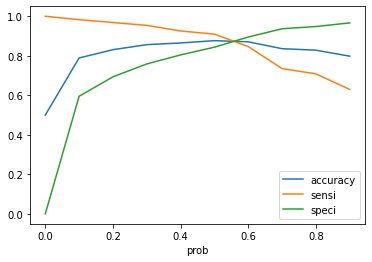

In [402]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [403]:
#From the curve above, 0.6 is the optimum point to take it as a cutoff probability
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.6 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.28,1,1,1,0,0,0,0,0,0,0,0
1,0,0.93,1,1,1,1,1,1,1,1,1,1,1
2,0,0.04,1,0,0,0,0,0,0,0,0,0,0
3,0,0.26,1,1,1,0,0,0,0,0,0,0,0
4,0,0.00,1,0,0,0,0,0,0,0,0,0,0


In [404]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.8707131774650901

In [405]:
recall_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.8467176716066556

In [406]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

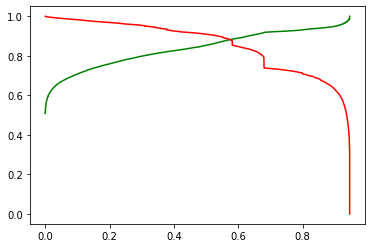

In [407]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [408]:
X_test_sm = sm.add_constant(X_test[col])
y_test_pred = res.predict(X_test_sm)
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
6845,0.00
34108,0.02
29957,0.57
28887,0.01
20725,0.17


In [409]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [410]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final.head()

,churn,0
6845,0,0.00
34108,0,0.02
29957,1,0.57
28887,0,0.01
20725,0,0.17


In [411]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})
y_pred_final.head()

,churn,Churn_Prob
6845,0,0.00
34108,0,0.02
29957,1,0.57
28887,0,0.01
20725,0,0.17


In [412]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.6 else 0)

In [413]:
recall_score(y_pred_final.churn, y_pred_final.final_predicted)

0.39636363636363636

In [414]:
res.params[0:10]

const             1.86
loc_ic_mou_8     -1.62
monthly_2g_6_1   -1.48
monthly_2g_6_2   -2.42
sachet_2g_6_1    -1.08
sachet_2g_6_2    -1.21
sachet_3g_6_2    -1.37
monthly_2g_7_2   -2.09
sachet_2g_7_12   -3.55
monthly_3g_7_3   -1.99
dtype: float64

In [415]:
res_feature=pd.DataFrame(res.params)
res_feature.reset_index(inplace=True)
res_feature.columns=['feature','coeff']
res_feature['abs_coeff']=np.abs(res_feature.coeff)
res_feature.sort_values('abs_coeff',ascending=False).head(20)

,feature,coeff,abs_coeff
18,sachet_2g_8_9,-5.45,5.45
17,sachet_2g_8_7,-5.08,5.08
35,aon_yrs_11,-4.60,4.60
15,sachet_2g_8_5,-4.36,4.36
21,monthly_3g_8_3,-4.32,4.32
23,sachet_3g_8_2,-4.23,4.23
24,sachet_3g_8_3,-4.20,4.20
31,aon_yrs_7,-4.01,4.01
34,aon_yrs_10,-3.84,3.84
13,sachet_2g_8_3,-3.69,3.69


### Using XGBoost

In [416]:
xgb_cfl = XGBClassifier(n_jobs = -1,objective = 'binary:logistic')
xgb_cfl.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [417]:
# Fit the model to our train and target
xgb_cfl.fit(X_train, y_train)  # Use the Non-PCA X_train so that we can get the important features

XGBClassifier(n_jobs=-1)

In [418]:
# Get our predictions
xgb_predictions = xgb_cfl.predict(X_test)

In [419]:
xgb_predictions_prob = xgb_cfl.predict_proba(X_test)
xgb_predictions_prob

array([[0.98969847, 0.01030151],
       [0.9624885 , 0.0375115 ],
       [0.40741974, 0.59258026],
       ...,
       [0.9201558 , 0.07984415],
       [0.9375176 , 0.0624824 ],
       [0.9669815 , 0.03301853]], dtype=float32)

In [420]:
recall_score(y_test, xgb_predictions)

0.7254545454545455

In [421]:
imp_xgb=pd.DataFrame({'Features':X_train.columns,'values':xgb_cfl.feature_importances_})
imp_xgb.sort_values('values',ascending=False).head(10)

,Features,values
14,roam_og_mou_8,0.09
68,loc_ic_mou_8,0.07
86,total_ic_mou_8,0.06
104,max_rech_amt_8,0.06
101,total_rech_amt_8,0.05
140,fb_user_8,0.05
107,last_day_rch_amt_8,0.02
49,spl_og_mou_7,0.02
98,total_rech_num_8,0.02
56,total_og_mou_8,0.02


### Using Random Forrest

In [422]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
print('Recall_train:',round(metrics.recall_score(y_train, y_train_pred)*100, 2),'Accuracy_train:', round(metrics.accuracy_score(y_train, y_train_pred),2))
X_test_pca = pca.transform(X_test)
y_test_pred = rf.predict(X_test)
print('Recall_test:', round(metrics.recall_score(y_test, y_test_pred)*100, 2), 'Accuracy_test:', round(metrics.accuracy_score(y_test, y_test_pred)))

Recall_train: 100.0 Accuracy_train: 1.0
Recall_test: 64.36 Accuracy_test: 1


In [423]:
imp_rf=pd.DataFrame({'Features':X_train.columns,'values':rf.feature_importances_})
imp_rf.sort_values('values',ascending=False).head(10)

,Features,values
11,roam_ic_mou_8,0.05
14,roam_og_mou_8,0.05
68,loc_ic_mou_8,0.05
62,loc_ic_t2m_mou_8,0.05
140,fb_user_8,0.04
101,total_rech_amt_8,0.04
2,arpu_8,0.03
104,max_rech_amt_8,0.03
107,last_day_rch_amt_8,0.03
86,total_ic_mou_8,0.03


## Feature Importance Results

In [424]:
# Important features through logistic regression
res_feature.sort_values('abs_coeff',ascending=False).head(10)

,feature,coeff,abs_coeff
18,sachet_2g_8_9,-5.45,5.45
17,sachet_2g_8_7,-5.08,5.08
35,aon_yrs_11,-4.60,4.60
15,sachet_2g_8_5,-4.36,4.36
21,monthly_3g_8_3,-4.32,4.32
23,sachet_3g_8_2,-4.23,4.23
24,sachet_3g_8_3,-4.20,4.20
31,aon_yrs_7,-4.01,4.01
34,aon_yrs_10,-3.84,3.84
13,sachet_2g_8_3,-3.69,3.69


In [425]:
# Important features through XGboost
imp_xgb.sort_values('values',ascending=False).head(20)

,Features,values
14,roam_og_mou_8,0.09
68,loc_ic_mou_8,0.07
86,total_ic_mou_8,0.06
104,max_rech_amt_8,0.06
101,total_rech_amt_8,0.05
140,fb_user_8,0.05
107,last_day_rch_amt_8,0.02
49,spl_og_mou_7,0.02
98,total_rech_num_8,0.02
56,total_og_mou_8,0.02


In [426]:
# Important features through Random forest
imp=pd.DataFrame({'Features':X_train.columns,'values':rf.feature_importances_})
imp_rf.sort_values('values',ascending=False).head(10)

,Features,values
11,roam_ic_mou_8,0.05
14,roam_og_mou_8,0.05
68,loc_ic_mou_8,0.05
62,loc_ic_t2m_mou_8,0.05
140,fb_user_8,0.04
101,total_rech_amt_8,0.04
2,arpu_8,0.03
104,max_rech_amt_8,0.03
107,last_day_rch_amt_8,0.03
86,total_ic_mou_8,0.03


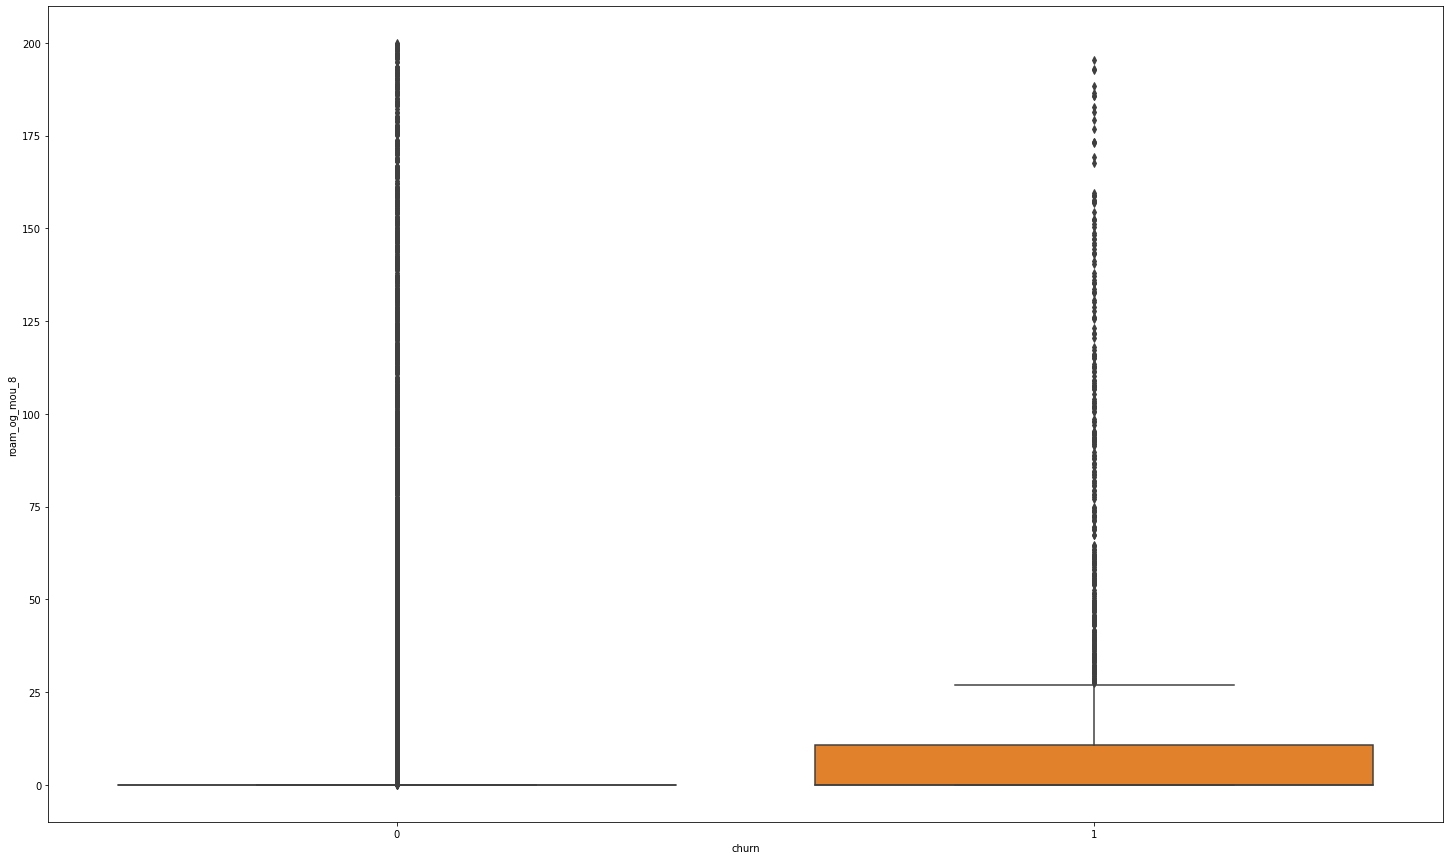

In [427]:
plt.figure(figsize=(25, 15))
tmp_df=df_hv[df_hv['roam_og_mou_8']<200]
sns.boxplot(x=tmp_df.churn,y=tmp_df.roam_og_mou_8)

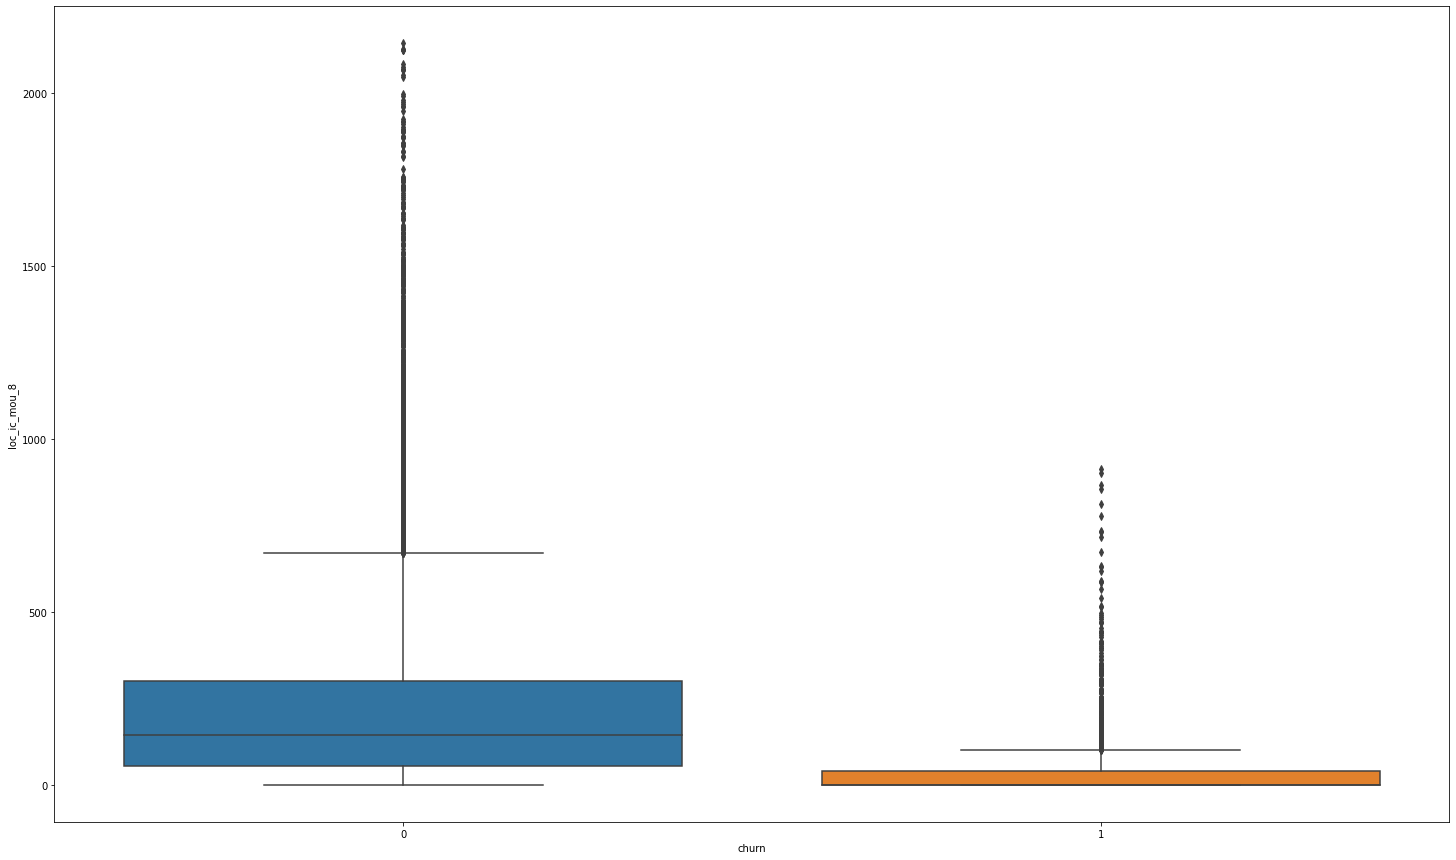

In [428]:
plt.figure(figsize=(25, 15))
tmp_df=df_hv
sns.boxplot(x=tmp_df.churn,y=tmp_df.loc_ic_mou_8)

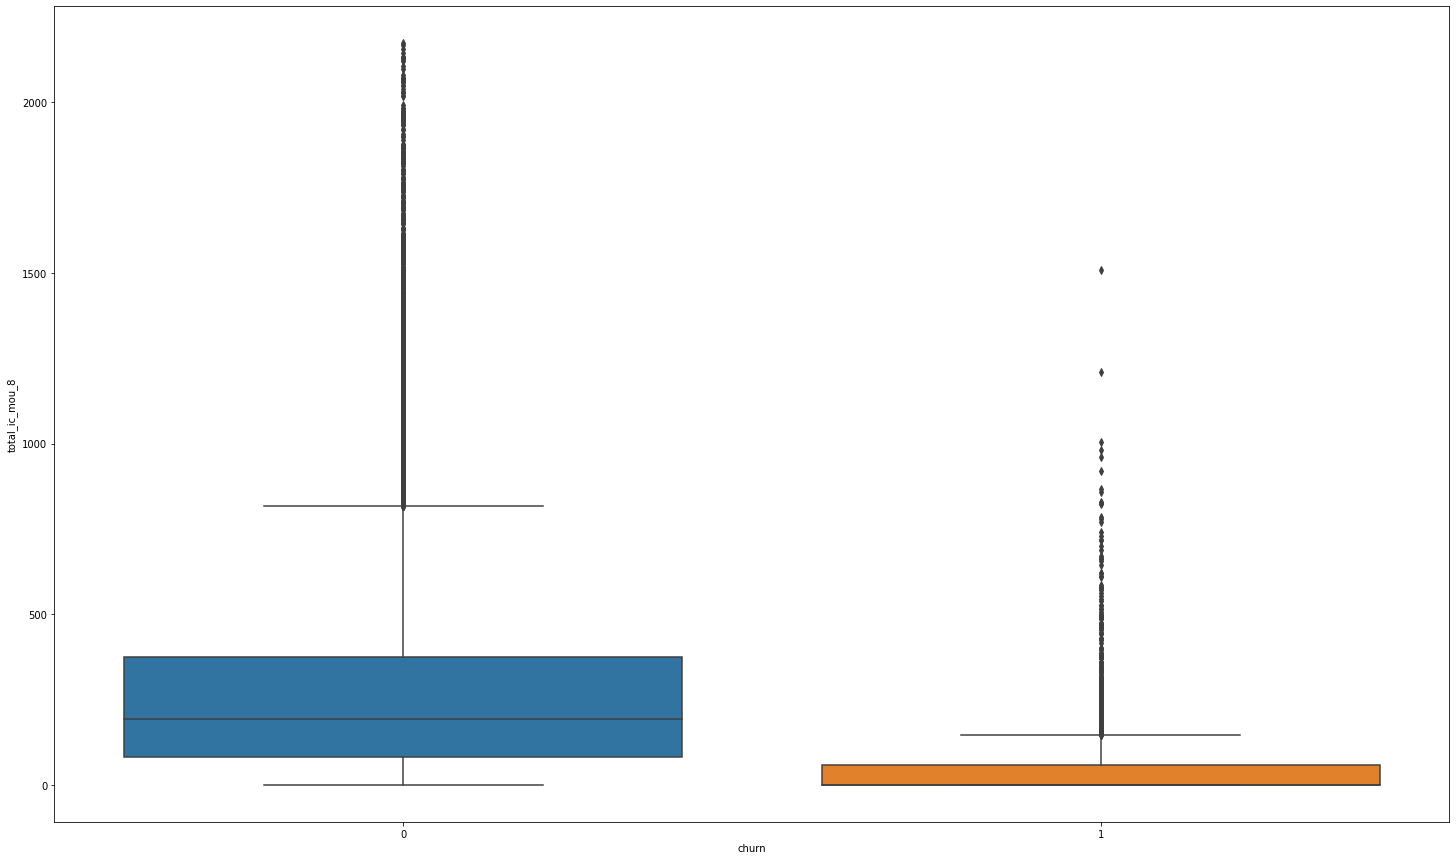

In [429]:
plt.figure(figsize=(25, 15))
tmp_df=df_hv
sns.boxplot(x=tmp_df.churn,y=tmp_df.total_ic_mou_8)

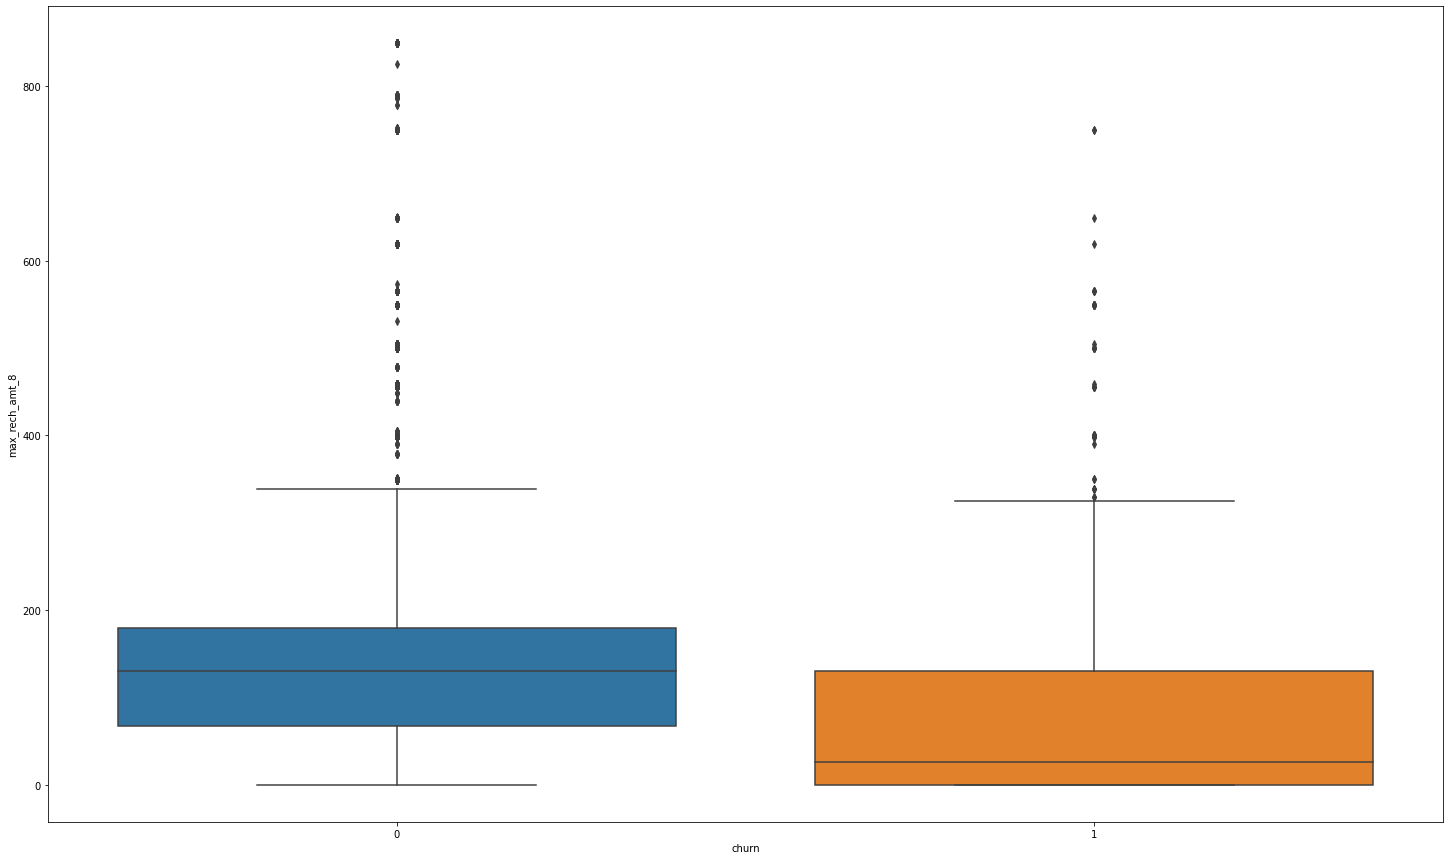

In [430]:
plt.figure(figsize=(25, 15))
tmp_df=df_hv
sns.boxplot(x=tmp_df.churn,y=tmp_df.max_rech_amt_8)

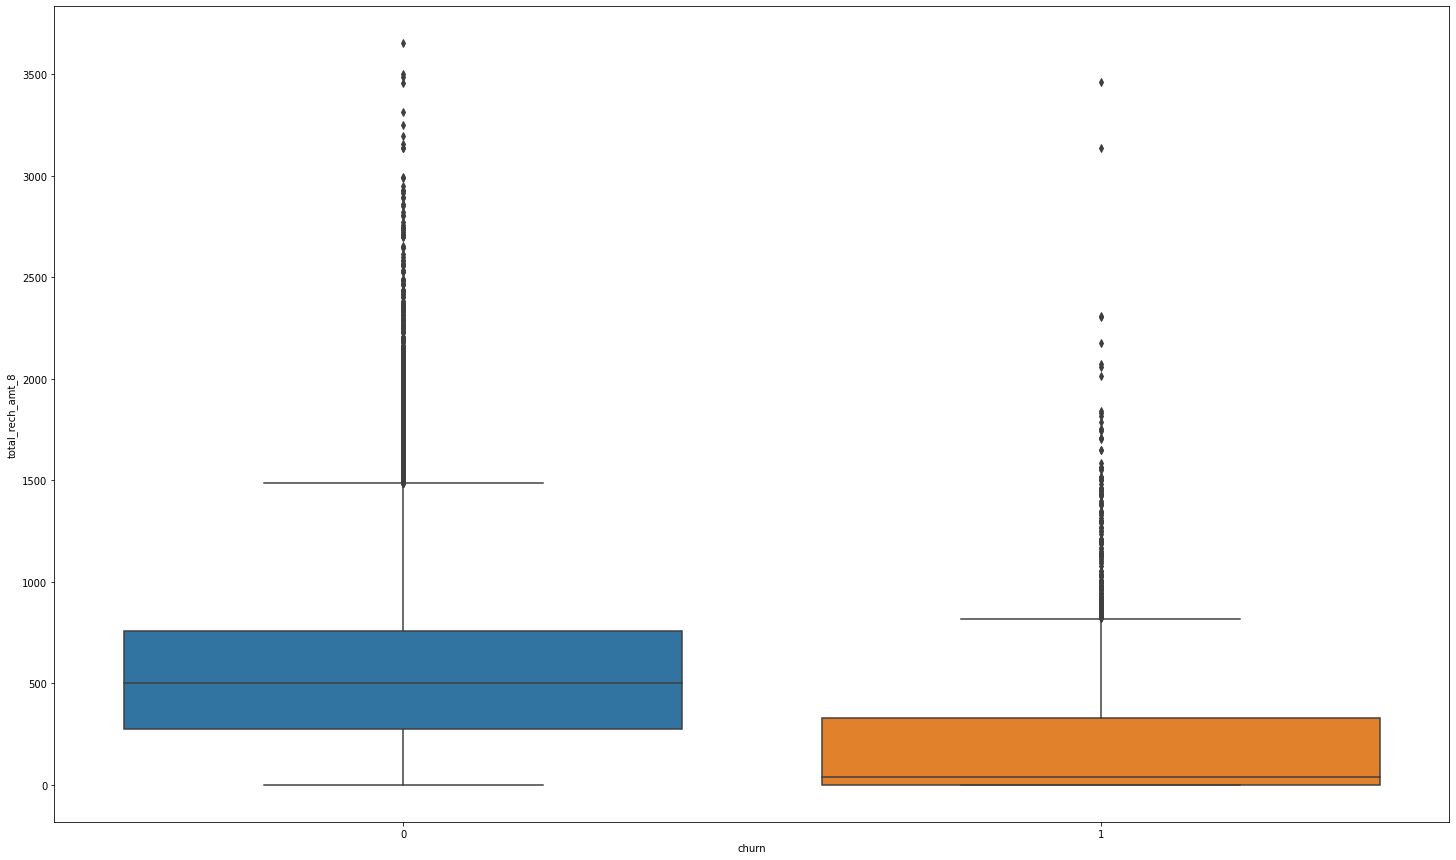

In [431]:
plt.figure(figsize=(25, 15))
tmp_df=df_hv
sns.boxplot(x=tmp_df.churn,y=tmp_df.total_rech_amt_8)

In [432]:
tmp_df[tmp_df.churn==1]['total_rech_amt_8'].median()

40.0

In [433]:
tmp_df[tmp_df.churn==1]['max_rech_amt_8'].median()

26.0

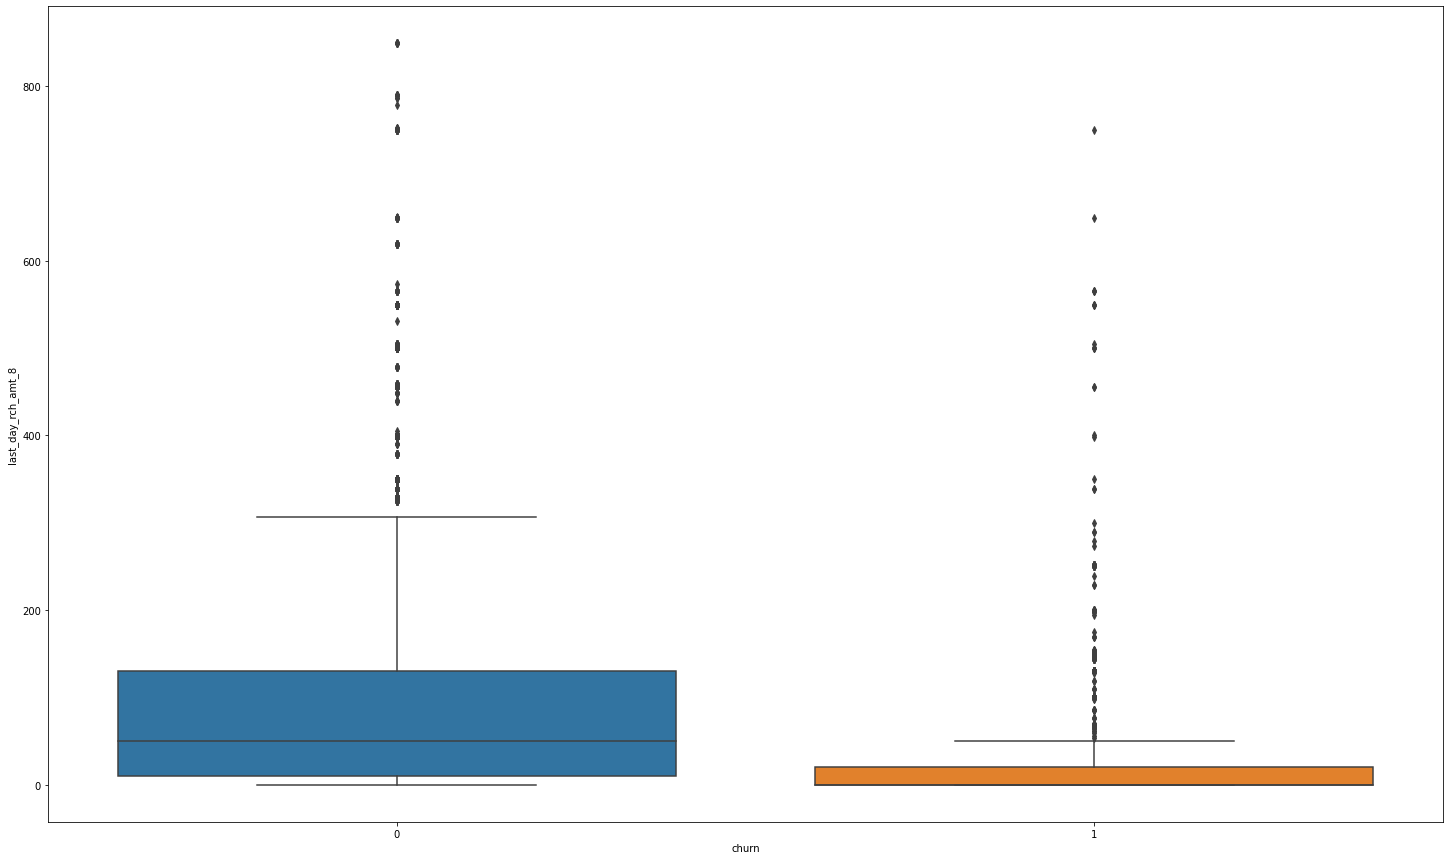

In [434]:
plt.figure(figsize=(25, 15))
tmp_df=df_hv
sns.boxplot(x=tmp_df.churn,y=tmp_df.last_day_rch_amt_8)

In [435]:
tmp_df[tmp_df.churn==1]['last_day_rch_amt_8'].median()

0.0

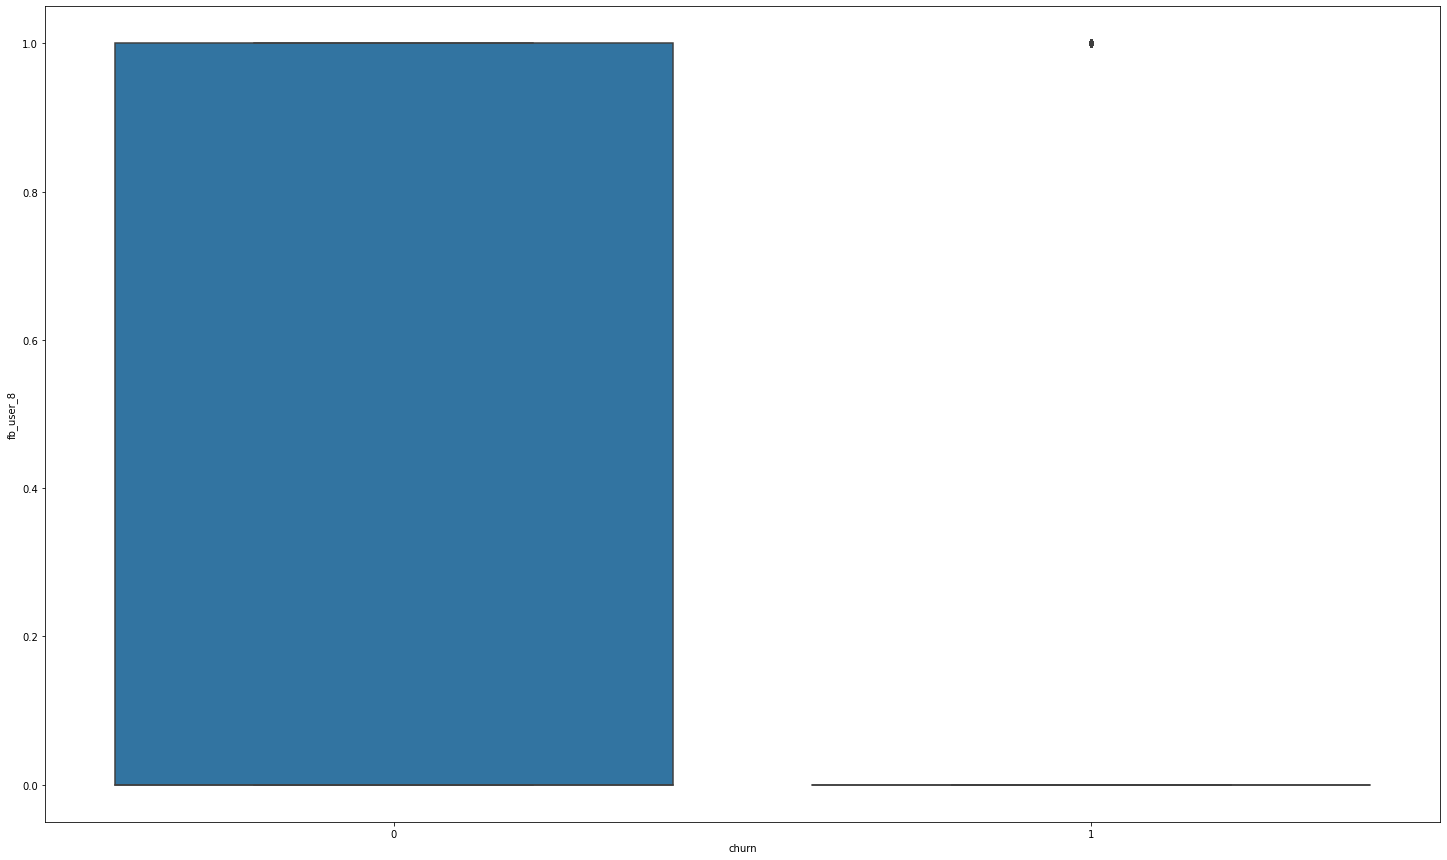

In [436]:
plt.figure(figsize=(25, 15))
tmp_df=df_hv
sns.boxplot(x=tmp_df.churn,y=tmp_df.fb_user_8)

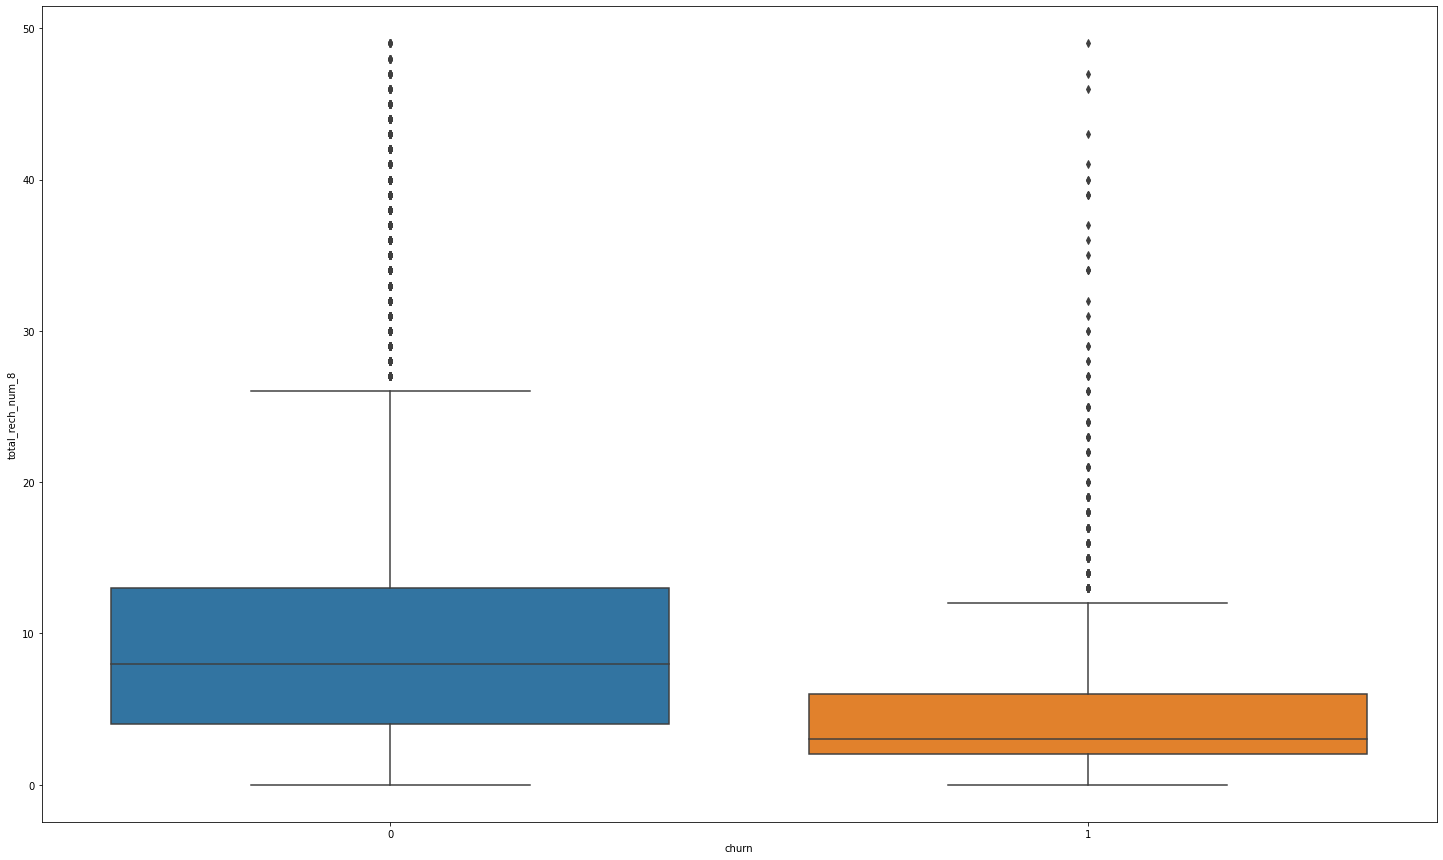

In [437]:
plt.figure(figsize=(25, 15))
tmp_df=df_hv[df_hv.total_rech_num_8<50]
sns.boxplot(x=tmp_df.churn,y=tmp_df.total_rech_num_8)

In [438]:
tmp_df[tmp_df.churn==1]['total_rech_num_8'].median()

3.0

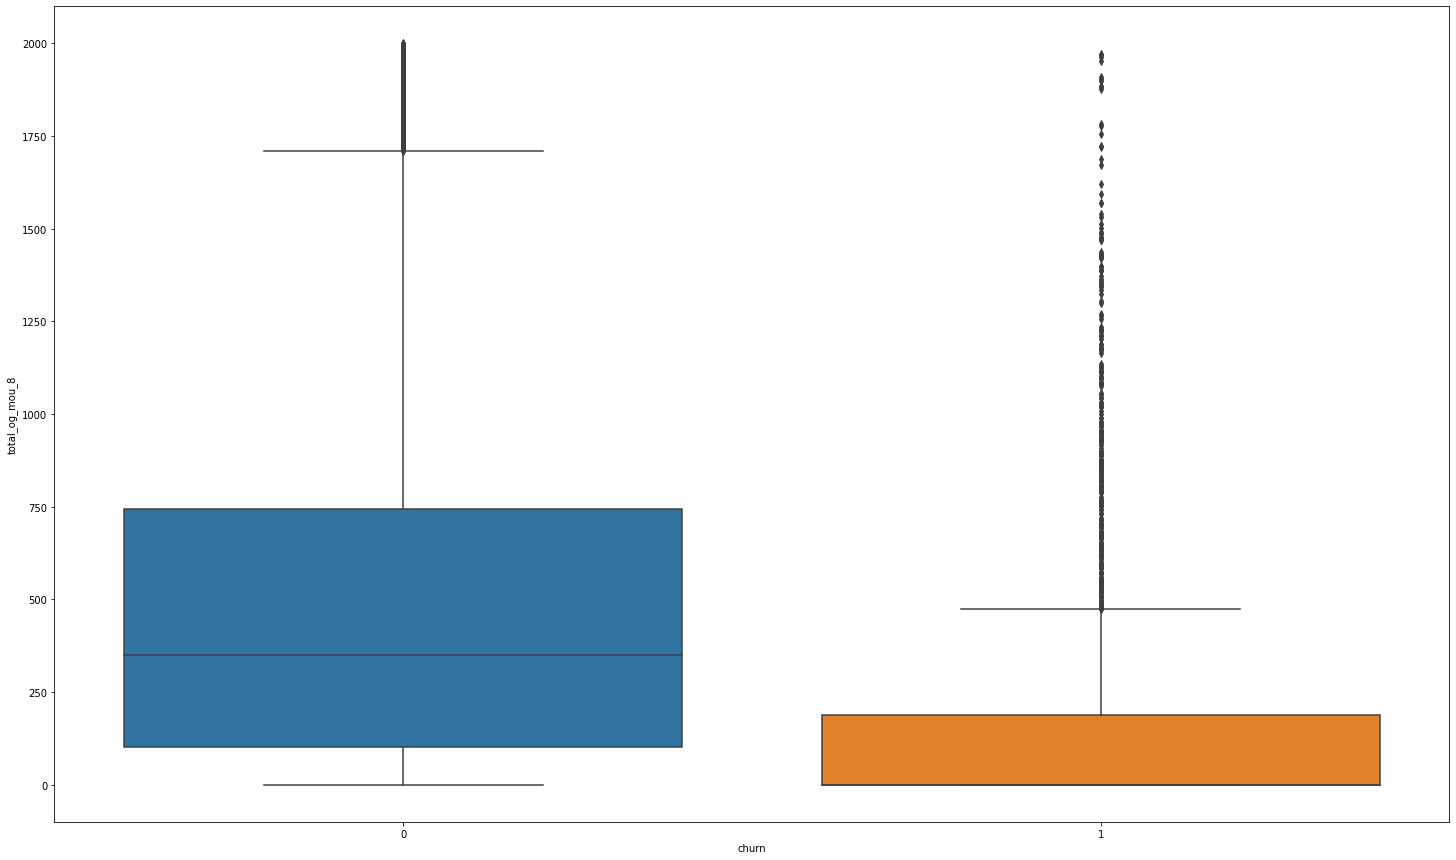

In [439]:
plt.figure(figsize=(25, 15))
tmp_df=df_hv[df_hv.total_og_mou_8<2000]
sns.boxplot(x=tmp_df.churn,y=tmp_df.total_og_mou_8)

In [440]:
tmp_df[tmp_df.churn==1]['total_og_mou_8'].median()

0.0

##Recomendations based on feature importance

>- Since the prime model with better recall score is XGboost feature importance are taken from it

>- roam_og_mou: Customers with higher roaming outgoing usage have higher churn. This could be because they may have to pay more for charges, hence prefer to buy local sim. To retain such customers, identify them and offer them either discounted roaming charges or local SIM on our network. Another option is to offer free roaming on own network.

>- fb_user: Customers who are fb_users have a very low churn %. Converting normal users to fb_users with attractive packages will ensure drastic reduction in churn.

>- total_recharge_amt: Customers who recharge more than Rs 40 have a lower chance of churn as can be seen from the median plotted for churn customers. So any customer whose total_recharge_amt is less than 40, needs to be reminded to recharge. Or an offer with recharge discounts can be provided to her. 

>- total_recharge_num: Customers who recharge less than 3 times a month, have a higher chance of churn. Reminders to recharge or offering some attractive packages will prevent churn

>- max_recharge_amt: Customers who have max recharge upto Rs 26 have a lower chance of churn as can be seen from the median. So any customer whose max_recharge_amt is less than Rs 26, needs to be reminded to recharge. Or an offer with recharge discounts can be provided to her. This should be used in conjunction with total_recharge_amt and if the user has recharged upto 40 then this should be ignored